### Semantic Persona Classification of USS Reviews

### Using Sentence Transformers and Cosine Similarity with Integrated Sentiment Analysis

### Objective
To develop and evaluate a comprehensive semantic-based machine learning model that classifies Universal Studios Singapore (USS) user reviews into six distinct visitor personas — **Families**, **Thrill Seekers**, **International Tourists**, **Budget Conscious**, **Premium Visitors**, and **Experience Focused** — using sentence transformer embeddings and cosine similarity matching, integrated with ensemble sentiment analysis for enhanced business intelligence.

---

### Dataset

#### Primary Dataset
- **Source**: `USS_Reviews_Silver_cleaned_l2.csv` (pre-processed Google Reviews)
- **Content**:
  - **Review Text**: Unstructured textual reviews
  - **Star Ratings**: Original 1-5 star user ratings  
  - **Temporal Data**: Published dates (`publishedAtDate`) spanning multiple years
  - **Review Metadata**: Review length, user information

#### Sentiment Analysis Integration
- **Source**: `google_reviews_adaptive_moe_results_classified.csv` (teammate's sentiment analysis results)
- **Content**:
  - **Ensemble Predictions**: 0 = Negative, 1 = Neutral, 2 = Positive
  - **Confidence Scores**: Sentiment prediction reliability scores
  - **Probability Distributions**: `prob_negative`, `prob_neutral`, `prob_positive`
  - **Review Index Mapping**: Links to primary dataset via `review_index`

#### Output Datasets
- **Enhanced Classification**: `USS_Reviews_Silver_cleaned_l3.csv` / `USS_Reviews_Silver_cleaned_l3.parquet`
- **Dashboard Data**: `USS_Reviews_Personas_Threshold_{CONFIDENCE_THRESHOLD}_with_sentiment.json`
- **Visualization Data**: `integrated_persona_analysis_threshold_{CONFIDENCE_THRESHOLD}_with_sentiment.json`

---

### Methodology

#### 1. Data Preprocessing & Loading
- Load primary reviews from `USS_Reviews_Silver_cleaned_l2.csv`
- Integrate sentiment predictions via `review_index`
- CUDA-enabled embedding generation
- Efficient batch processing for >100K reviews

#### 2. Semantic Embedding Generation
- **Model**: `BAAI/bge-large-en-v1.5` sentence transformer
- **Hardware**: GPU with CPU fallback
- **Batch Size**: 512
- **Speed**: ~1,000+ reviews/second

#### 3. Persona Definition Framework
Each persona is defined via semantic descriptions including positive and negative indicators:
- **Families**: Family-friendly activities, child safety
- **Thrill Seekers**: Intense rides, adrenaline experiences
- **International Tourists**: First-time Singapore visitors
- **Budget Conscious**: Price-sensitive feedback
- **Premium Visitors**: VIP services, express passes
- **Experience Focused**: Operational issues, poor service

#### 4. Classification Pipeline
- Cosine similarity between review and persona embeddings
- Multi-persona detection (primary/secondary/tertiary)
- Confidence gap analysis for uncertainty detection
- Configurable threshold (default: 0.5)

#### 5. Sentiment Integration
- Combine original star ratings (1–5) with AI sentiment predictions (0–2)
- Analyze consistency and gaps
- Track sentiment evolution over time per persona

#### 6. Advanced Analytics
- **UMAP** for 2D cluster visualization
- **Temporal trend tracking** by persona
- **Top review extraction** per sentiment/persona
- **Mixed persona identification** via confidence gaps

---

### Technical Implementation

#### Performance Optimization
```python
# GPU-accelerated batch processing
batch_size = 512
device = 'cuda' if torch.cuda.is_available() else 'cpu'
similarity_matrix = cosine_similarity(review_embeddings, persona_matrix)
```
### Quality Assurance
- **Multi-threshold filtering** (0.3, 0.4, 0.5, 0.6)
- **Confidence gap detection** (< 0.1)
- **Star rating vs sentiment prediction cross-check**

### Output Formats
- **Enhanced CSV / Parquet** files with similarity matrices
- **Dashboard-ready JSONs**
- **Monthly trend tracking data**

### Evaluation Metrics

#### Classification Performance
- **Persona distribution analysis**
- **Confidence stats** (mean, median, min, max)
- **Mixed persona pattern detection**
- **Manual review candidates** based on low confidence gap

#### Validation Methods
- **Star rating correlation** with predicted sentiment
- **Month-over-month persona consistency**
- **Dual rating system alignment checks**
- **High-confidence sample inspection**

#### Business Intelligence Outputs
- **Monthly persona-level operational insights**
- **Sentiment evolution tracking** per persona
- **Representative reviews** for internal reporting
- **Dashboard integration via JSON**

---

### Key Innovations
1. **Semantic Precision**: Embedding-based classification without keyword dependence  
2. **Dual Rating Integration**: Combines human star ratings with AI sentiment  
3. **Confidence-Based Quality Control**: Multi-threshold validation  
4. **Temporal Intelligence**: Persona sentiment trends over time  
5. **Interactive Output**: Dashboard-ready data formats

---

### Expected Outcomes
- **Persona Classification**: ≥85% with confidence > 0.5  
- **Sentiment Alignment**: Validated dual rating system  
- **Actionable Insights**: Monthly persona-based satisfaction tracking  
- **Reusable Pipeline**: Adaptable for other theme parks or review-based analysis



### Phase 1: Data Loading & Environment Setup

In [3]:
# 1.1 Environment Configuration & Data Loading

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print(" Business-Oriented USS Review Analysis")
print("=" * 50)

# Define project paths
project_root = Path('.').resolve().parent
data_path = project_root / 'data' / 'processed'

print(f"Loading data from: {data_path}")

# Load the cleaned dataset
df = pd.read_csv(data_path / 'USS_Reviews_Silver_cleaned_l2.csv')

print(f"Dataset prepared: {len(df):,} reviews")
print(f"Date range: {df['publishedAtDate'].min()} to {df['publishedAtDate'].max()}")
print(f"Star rating distribution:")
print(df['stars'].value_counts().sort_index())

 Business-Oriented USS Review Analysis
Loading data from: C:\Users\nshan\Desktop\SMU\MITB\CS605\CS605-Sam\data\processed
Dataset prepared: 24,021 reviews
Date range: 2018-07-29 to 2025-05-23
Star rating distribution:
stars
1     1311
2      796
3     1982
4     4851
5    15081
Name: count, dtype: int64


### Phase 2: Semantic Model Initialization

In [5]:
# Install and import required libraries
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import torch

# Check GPU availability
print(f"CUDA available: {torch.cuda.is_available()}")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

CUDA available: True
Using device: cuda


In [6]:
#2.2 Model Loading & Persona Definition

# Load sentence transformer model
model_name = 'BAAI/bge-large-en-v1.5'  # Good balance of speed and quality
print(f"\nLoading model: {model_name}")
sentence_model = SentenceTransformer(model_name, device=device)
print("Model loaded successfully!")

# Simplified persona definitions (pure descriptions for semantic matching)
persona_descriptions = {
    'families': """Parents with young children and teenagers. Key phrases: "with kids", "children", "family", 
    "parents", "suitable for kids", "child-friendly", "age-appropriate", "family bonding", "stroller", 
    "educational for children", "traveling with family", "good for kids and parents".
    
    NEGATIVE INDICATORS: Does NOT mention solo travel, adrenaline, scary rides, first-time Singapore visit, 
    price complaints, express passes, queue problems, staff issues, maintenance problems.""",
    

    'thrill_seekers': """Adrenaline junkies focused on intense rides. Key phrases: "adrenaline", "scary", 
    "intense", "thrilling", "roller coaster", "extreme", "heart-pounding", "not for faint hearted", 
    "test of courage", "fear factor", "exciting and tense", "adrenaline rush", "challenging rides".
    
    NEGATIVE INDICATORS: Does NOT mention family activities, children, Singapore tourism, cost concerns, 
    VIP services, operational complaints, staff problems, maintenance issues.""",

    'international_tourists': """Foreign visitors to Singapore discussing travel planning. Key phrases: 
    "first time in Singapore", "visiting Singapore", "must visit", "bucket list", "travel to Singapore", 
    "Singapore attractions", "tourist destination", "once in lifetime", "Singapore itinerary", "foreign tourists".
    
    NEGATIVE INDICATORS: Does NOT mention family activities, adrenaline rides, price complaints, 
    premium services, operational issues, staff problems, local resident experiences.""",
    
    'budget_conscious': """Visitors angry about high costs and poor value. Key phrases: "expensive", 
    "overpriced", "not worth the money", "waste of money", "too expensive", "jaw-breaking expensive", 
    "insane prices", "poor value", "financially disappointed", "ripped off", "budget constraints".
    
    NEGATIVE INDICATORS: Does NOT mention family fun, thrilling experiences, Singapore tourism, 
    premium services, positive service experiences, adrenaline activities.""",
    
    'premium_visitors': """Users who bought or recommend paid upgrades. Key phrases: "express pass", 
    "VIP", "fast track", "skip the line", "priority access", "bought express", "recommend express", 
    "worth buying express", "VIP experience", "premium service", "exclusive access", "personal guide".
    
    NEGATIVE INDICATORS: Does NOT mention cost complaints, family-specific needs, adrenaline seeking, 
    Singapore travel planning, operational complaints, basic ticket experiences.""",
    
    'experience_focused': """Visitors complaining about operations and service quality. Key phrases: 
    "long queues", "waiting time", "staff attitude", "poor service", "maintenance issues", "attraction closed", 
    "crowd management", "facility problems", "operational issues", "park management", "service quality".
    
    NEGATIVE INDICATORS: Does NOT mention price concerns, family activities, thrill experiences, 
    Singapore tourism, premium services, positive experiences."""
}

print(f"\nGenerating embeddings for {len(persona_descriptions)} personas...")

# Generate embeddings for persona descriptions
persona_embeddings = {}
for persona, description in persona_descriptions.items():
    embedding = sentence_model.encode([description])
    persona_embeddings[persona] = embedding[0]
    print(f"✓ {persona}: embedding shape {embedding.shape}")

print("\nPersona embeddings ready for classification!")


Loading model: BAAI/bge-large-en-v1.5
Model loaded successfully!

Generating embeddings for 6 personas...
✓ families: embedding shape (1, 1024)
✓ thrill_seekers: embedding shape (1, 1024)
✓ international_tourists: embedding shape (1, 1024)
✓ budget_conscious: embedding shape (1, 1024)
✓ premium_visitors: embedding shape (1, 1024)
✓ experience_focused: embedding shape (1, 1024)

Persona embeddings ready for classification!


###  Phase 3: Embedding Generation & Classification

In [7]:
# 3.1 Batch Review Embedding Generation

import time
from tqdm import tqdm

print("Starting batch review classification...")
print("=" * 50)

# Prepare review data
reviews_list = df['review'].tolist()
total_reviews = len(reviews_list)

print(f"Total reviews to classify: {total_reviews:,}")
print(f"Batch processing on {device.upper()}")

# Set batch size for efficient GPU processing
batch_size = 512  # Adjust based on GPU memory
print(f"Batch size: {batch_size}")

# Generate embeddings for all reviews in batches
print("\nGenerating review embeddings...")
start_time = time.time()

all_review_embeddings = []
for i in tqdm(range(0, total_reviews, batch_size), desc="Processing batches"):
    batch = reviews_list[i:i + batch_size]
    batch_embeddings = sentence_model.encode(batch, device=device, show_progress_bar=False)
    all_review_embeddings.extend(batch_embeddings)

review_embeddings = np.array(all_review_embeddings)
end_time = time.time()

print(f"\n✓ Generated embeddings for {total_reviews:,} reviews")
print(f"Processing time: {end_time - start_time:.2f} seconds")
print(f"Embedding matrix shape: {review_embeddings.shape}")
print(f"Speed: {total_reviews / (end_time - start_time):.0f} reviews/second")

Starting batch review classification...
Total reviews to classify: 24,021
Batch processing on CUDA
Batch size: 512

Generating review embeddings...


Processing batches: 100%|██████████| 47/47 [04:12<00:00,  5.38s/it]


✓ Generated embeddings for 24,021 reviews
Processing time: 252.90 seconds
Embedding matrix shape: (24021, 1024)
Speed: 95 reviews/second


In [8]:
# 3.2 Cosine Similarity Calculation & Initial Classification

print("Computing persona similarities and classifications...")
print("=" * 50)

# Convert persona embeddings to numpy array for efficient computation
persona_names = list(persona_embeddings.keys())
persona_matrix = np.array([persona_embeddings[name] for name in persona_names])

print(f"Persona matrix shape: {persona_matrix.shape}")
print(f"Review matrix shape: {review_embeddings.shape}")

# Calculate cosine similarities between all reviews and all personas
print("\nCalculating cosine similarities...")
start_time = time.time()

# Use sklearn's efficient cosine similarity
similarity_matrix = cosine_similarity(review_embeddings, persona_matrix)

end_time = time.time()
print(f"Similarity calculation completed in {end_time - start_time:.2f} seconds")
print(f"Similarity matrix shape: {similarity_matrix.shape}")

# Classify each review to the most similar persona
print("\nClassifying reviews...")

# Get the persona with highest similarity for each review
best_persona_indices = np.argmax(similarity_matrix, axis=1)
best_similarities = np.max(similarity_matrix, axis=1)

# Create classification results
classification_results = []
for i, (persona_idx, similarity) in enumerate(zip(best_persona_indices, best_similarities)):
    classification_results.append({
        'review_index': i,
        'best_persona': persona_names[persona_idx],
        'confidence': similarity,
        'all_similarities': dict(zip(persona_names, similarity_matrix[i]))
    })

print(f"✓ Classified {len(classification_results):,} reviews")

# Quick statistics
print(f"\nClassification confidence statistics:")
print(f"Mean confidence: {np.mean(best_similarities):.3f}")
print(f"Median confidence: {np.median(best_similarities):.3f}")
print(f"Min confidence: {np.min(best_similarities):.3f}")
print(f"Max confidence: {np.max(best_similarities):.3f}")

Computing persona similarities and classifications...
Persona matrix shape: (6, 1024)
Review matrix shape: (24021, 1024)

Calculating cosine similarities...
Similarity calculation completed in 0.62 seconds
Similarity matrix shape: (24021, 6)

Classifying reviews...
✓ Classified 24,021 reviews

Classification confidence statistics:
Mean confidence: 0.543
Median confidence: 0.550
Min confidence: 0.302
Max confidence: 0.762


### Phase 4: Classification Analysis & Validation

In [10]:
# 4.1 Initial Classification Results Analysis

print("Classification Distribution Analysis")
print("=" * 50)

# Add classification results to dataframe
df_classified = df.copy()
df_classified['predicted_persona'] = [result['best_persona'] for result in classification_results]
df_classified['confidence'] = [result['confidence'] for result in classification_results]

# 1. Overall distribution
print("1. PERSONA DISTRIBUTION:")
persona_counts = df_classified['predicted_persona'].value_counts()
persona_percentages = (persona_counts / len(df_classified) * 100).round(1)

for persona in persona_names:
    count = persona_counts.get(persona, 0)
    pct = persona_percentages.get(persona, 0)
    print(f"   {persona:20}: {count:5,} reviews ({pct:5.1f}%)")

# 2. Confidence distribution by persona
print(f"\n2. CONFIDENCE BY PERSONA:")
for persona in persona_names:
    persona_data = df_classified[df_classified['predicted_persona'] == persona]
    if len(persona_data) > 0:
        mean_conf = persona_data['confidence'].mean()
        std_conf = persona_data['confidence'].std()
        print(f"   {persona:20}: {mean_conf:.3f} ± {std_conf:.3f}")

# 3. Star rating correlation
print(f"\n3. PERSONA vs STAR RATING:")
persona_star_crosstab = pd.crosstab(df_classified['predicted_persona'], df_classified['stars'], normalize='index') * 100
print(persona_star_crosstab.round(1))

# 4. High confidence samples (top 3 per persona)
print(f"\n4. HIGH CONFIDENCE SAMPLES:")
print("=" * 60)

for persona in persona_names:
    persona_data = df_classified[df_classified['predicted_persona'] == persona]
    if len(persona_data) > 0:
        top_samples = persona_data.nlargest(8, 'confidence')
        print(f"\n{persona.upper()} (Top 8 high confidence):")
        for idx, row in top_samples.iterrows():
            print(f"   Confidence: {row['confidence']:.3f} | Stars: {row['stars']}")
            print(f"   Review: \"{row['review'][:350]}...\"")
            print()

Classification Distribution Analysis
1. PERSONA DISTRIBUTION:
   families            : 5,076 reviews ( 21.1%)
   thrill_seekers      : 3,141 reviews ( 13.1%)
   international_tourists: 3,649 reviews ( 15.2%)
   budget_conscious    : 1,323 reviews (  5.5%)
   premium_visitors    : 2,914 reviews ( 12.1%)
   experience_focused  : 7,918 reviews ( 33.0%)

2. CONFIDENCE BY PERSONA:
   families            : 0.519 ± 0.073
   thrill_seekers      : 0.504 ± 0.064
   international_tourists: 0.541 ± 0.070
   budget_conscious    : 0.527 ± 0.074
   premium_visitors    : 0.549 ± 0.076
   experience_focused  : 0.575 ± 0.069

3. PERSONA vs STAR RATING:
stars                      1    2     3     4     5
predicted_persona                                  
budget_conscious        10.4  7.6  16.3  20.9  44.7
experience_focused      13.5  7.9  16.2  26.2  36.2
families                 0.4  0.5   3.9  19.7  75.6
international_tourists   0.4  0.3   1.8  12.9  84.6
premium_visitors         2.1  0.8   5.2  19.3

In [11]:
# 4.2 Enhanced Multi-Persona Classification Analysis

print("Computing persona similarities and classifications...")
print("=" * 50)

# Convert persona embeddings to numpy array for efficient computation
persona_names = list(persona_embeddings.keys())
persona_matrix = np.array([persona_embeddings[name] for name in persona_names])

print(f"Persona matrix shape: {persona_matrix.shape}")
print(f"Review matrix shape: {review_embeddings.shape}")

# Calculate cosine similarities between all reviews and all personas
print("\nCalculating cosine similarities...")
start_time = time.time()

# Use sklearn's efficient cosine similarity
similarity_matrix = cosine_similarity(review_embeddings, persona_matrix)

end_time = time.time()
print(f"Similarity calculation completed in {end_time - start_time:.2f} seconds")
print(f"Similarity matrix shape: {similarity_matrix.shape}")

# Classify each review to the most similar persona
print("\nClassifying reviews...")

# Get the persona with highest similarity for each review
best_persona_indices = np.argmax(similarity_matrix, axis=1)
best_similarities = np.max(similarity_matrix, axis=1)

# Create detailed classification results with ALL similarities
classification_results = []
for i, (persona_idx, similarity) in enumerate(zip(best_persona_indices, best_similarities)):
    all_similarities = dict(zip(persona_names, similarity_matrix[i]))
    
    # Calculate confidence gap (difference between top 2 scores)
    sorted_similarities = sorted(similarity_matrix[i], reverse=True)
    confidence_gap = sorted_similarities[0] - sorted_similarities[1] if len(sorted_similarities) > 1 else 0
    
    # Find secondary persona
    secondary_idx = np.argsort(similarity_matrix[i])[-2]  # Second highest
    secondary_persona = persona_names[secondary_idx]
    secondary_confidence = similarity_matrix[i][secondary_idx]
    
    classification_results.append({
        'review_index': i,
        'best_persona': persona_names[persona_idx],
        'confidence': similarity,
        'secondary_persona': secondary_persona,
        'secondary_confidence': secondary_confidence,
        'confidence_gap': confidence_gap,
        'all_similarities': all_similarities
    })

print(f"Classified {len(classification_results):,} reviews")

# Quick statistics
print(f"\nClassification confidence statistics:")
print(f"Mean confidence: {np.mean(best_similarities):.3f}")
print(f"Median confidence: {np.median(best_similarities):.3f}")
print(f"Min confidence: {np.min(best_similarities):.3f}")
print(f"Max confidence: {np.max(best_similarities):.3f}")

# Confidence gap statistics
confidence_gaps = [result['confidence_gap'] for result in classification_results]
print(f"\nConfidence gap statistics:")
print(f"Mean gap: {np.mean(confidence_gaps):.3f}")
print(f"Median gap: {np.median(confidence_gaps):.3f}")
print(f"Min gap: {np.min(confidence_gaps):.3f}")
print(f"Max gap: {np.max(confidence_gaps):.3f}")

Computing persona similarities and classifications...
Persona matrix shape: (6, 1024)
Review matrix shape: (24021, 1024)

Calculating cosine similarities...
Similarity calculation completed in 0.20 seconds
Similarity matrix shape: (24021, 6)

Classifying reviews...
Classified 24,021 reviews

Classification confidence statistics:
Mean confidence: 0.543
Median confidence: 0.550
Min confidence: 0.302
Max confidence: 0.762

Confidence gap statistics:
Mean gap: 0.034
Median gap: 0.025
Min gap: 0.000
Max gap: 0.215


In [12]:
# 4.3 Comprehensive Classification Results Analysis & Data Export

print("\nClassification Distribution Analysis")
print("=" * 50)

# Add classification results to dataframe
df_classified = df.copy()
df_classified['predicted_persona'] = [result['best_persona'] for result in classification_results]
df_classified['confidence'] = [result['confidence'] for result in classification_results]
df_classified['secondary_persona'] = [result['secondary_persona'] for result in classification_results]
df_classified['secondary_confidence'] = [result['secondary_confidence'] for result in classification_results]
df_classified['confidence_gap'] = [result['confidence_gap'] for result in classification_results]

# Add all similarity scores as separate columns
for persona in persona_names:
    df_classified[f'{persona}_similarity'] = [result['all_similarities'][persona] for result in classification_results]

# 1. Overall distribution
print("1. PERSONA DISTRIBUTION:")
persona_counts = df_classified['predicted_persona'].value_counts()
persona_percentages = (persona_counts / len(df_classified) * 100).round(1)

for persona in persona_names:
    count = persona_counts.get(persona, 0)
    pct = persona_percentages.get(persona, 0)
    print(f"   {persona:20}: {count:5,} reviews ({pct:5.1f}%)")

# 2. Confidence distribution by persona
print(f"\n2. CONFIDENCE BY PERSONA:")
for persona in persona_names:
    persona_data = df_classified[df_classified['predicted_persona'] == persona]
    if len(persona_data) > 0:
        mean_conf = persona_data['confidence'].mean()
        std_conf = persona_data['confidence'].std()
        mean_gap = persona_data['confidence_gap'].mean()
        print(f"   {persona:20}: {mean_conf:.3f} ± {std_conf:.3f} (gap: {mean_gap:.3f})")

# 3. Star rating correlation
print(f"\n3. PERSONA vs STAR RATING:")
persona_star_crosstab = pd.crosstab(df_classified['predicted_persona'], df_classified['stars'], normalize='index') * 100
print(persona_star_crosstab.round(1))

# 4. NEW: Mixed personas analysis (small confidence gaps)
print(f"\n4. MIXED PERSONA PATTERNS:")
print("Top persona combinations with small confidence gaps (<0.05):")
mixed_reviews = df_classified[df_classified['confidence_gap'] < 0.05]
if len(mixed_reviews) > 0:
    mixed_combinations = mixed_reviews.groupby(['predicted_persona', 'secondary_persona']).size().sort_values(ascending=False)
    for (primary, secondary), count in mixed_combinations.head(10).items():
        pct = count / len(df_classified) * 100
        print(f"   {primary} + {secondary}: {count} reviews ({pct:.1f}%)")
else:
    print("   No reviews with confidence gap < 0.05")

# 5. NEW: Uncertain classifications
print(f"\n5. UNCERTAIN CLASSIFICATIONS:")
uncertain_threshold = 0.1
uncertain_reviews = df_classified[df_classified['confidence_gap'] < uncertain_threshold]
print(f"Reviews with confidence gap < {uncertain_threshold}: {len(uncertain_reviews)} ({len(uncertain_reviews)/len(df_classified)*100:.1f}%)")

if len(uncertain_reviews) > 0:
    print("\nTop uncertain classification examples:")
    uncertain_samples = uncertain_reviews.nsmallest(5, 'confidence_gap')
    for idx, row in uncertain_samples.iterrows():
        print(f"   Gap: {row['confidence_gap']:.3f} | {row['predicted_persona']} ({row['confidence']:.3f}) vs {row['secondary_persona']} ({row['secondary_confidence']:.3f})")
        print(f"   Review: \"{row['review'][:100]}...\"")
        print()

# 6. High confidence samples (top 3 per persona)
print(f"\n6. HIGH CONFIDENCE SAMPLES:")
print("=" * 60)

for persona in persona_names:
    persona_data = df_classified[df_classified['predicted_persona'] == persona]
    if len(persona_data) > 0:
        top_samples = persona_data.nlargest(8, 'confidence')
        print(f"\n{persona.upper()} (Top 8 high confidence):")
        for idx, row in top_samples.iterrows():
            print(f"   Confidence: {row['confidence']:.3f} | Gap: {row['confidence_gap']:.3f} | Stars: {row['stars']}")
            print(f"   Secondary: {row['secondary_persona']} ({row['secondary_confidence']:.3f})")
            print(f"   Review: \"{row['review'][:200]}...\"")
            print()


print(f"\n8. SAVE ENHANCED RESULTS:")

processed_path = project_root / 'data' / 'processed'

processed_path.mkdir(parents=True, exist_ok=True)

csv_file = 'USS_Reviews_Silver_cleaned_l3.csv'
parquet_file = 'USS_Reviews_Silver_cleaned_l3.parquet'

csv_path = processed_path / csv_file
parquet_path = processed_path / parquet_file

# save as csv
print(f"Saving CSV to: {csv_path}")
df_classified.to_csv(csv_path, index=False)
print(f"✓ Enhanced classification results saved to '{csv_path}'")

# save as parquet
print(f"Saving Parquet to: {parquet_path}")
df_classified.to_parquet(parquet_path, index=False)
print(f"✓ Enhanced classification results saved to '{parquet_path}'")

print(f"✓ Includes all {len(persona_names)} persona similarity scores for each review")
print(f"✓ Total columns: {len(df_classified.columns)}")
print(f"✓ Total rows: {len(df_classified):,}")

# compare size
import os
csv_size = os.path.getsize(csv_path) / (1024*1024)  # MB
parquet_size = os.path.getsize(parquet_path) / (1024*1024)  # MB

print(f"\nFile size comparison:")
print(f"  CSV: {csv_size:.1f} MB")
print(f"  Parquet: {parquet_size:.1f} MB")
print(f"  Space savings: {((csv_size - parquet_size) / csv_size * 100):.1f}%")

print(f"\nNext time you can load either format:")
print(f"  df = pd.read_csv('{csv_path}')")
print(f"  df = pd.read_parquet('{parquet_path}')  # Faster loading")


Classification Distribution Analysis
1. PERSONA DISTRIBUTION:
   families            : 5,076 reviews ( 21.1%)
   thrill_seekers      : 3,141 reviews ( 13.1%)
   international_tourists: 3,649 reviews ( 15.2%)
   budget_conscious    : 1,323 reviews (  5.5%)
   premium_visitors    : 2,914 reviews ( 12.1%)
   experience_focused  : 7,918 reviews ( 33.0%)

2. CONFIDENCE BY PERSONA:
   families            : 0.519 ± 0.073 (gap: 0.039)
   thrill_seekers      : 0.504 ± 0.064 (gap: 0.028)
   international_tourists: 0.541 ± 0.070 (gap: 0.025)
   budget_conscious    : 0.527 ± 0.074 (gap: 0.025)
   premium_visitors    : 0.549 ± 0.076 (gap: 0.032)
   experience_focused  : 0.575 ± 0.069 (gap: 0.039)

3. PERSONA vs STAR RATING:
stars                      1    2     3     4     5
predicted_persona                                  
budget_conscious        10.4  7.6  16.3  20.9  44.7
experience_focused      13.5  7.9  16.2  26.2  36.2
families                 0.4  0.5   3.9  19.7  75.6
international_tour

###  Phase 5: Visualization & Embedding Analysis

Creating ENHANCED embedding visualization with fixed label positioning
Applying confidence threshold: 0.65
High confidence samples: 1447 / 24021 (6.0%)
Final visualization sample: 1447 high-confidence embeddings
Running enhanced UMAP with optimized parameters...
Enhanced UMAP completed! Shape: (1447, 2)
Calculating confidence-weighted centroids...


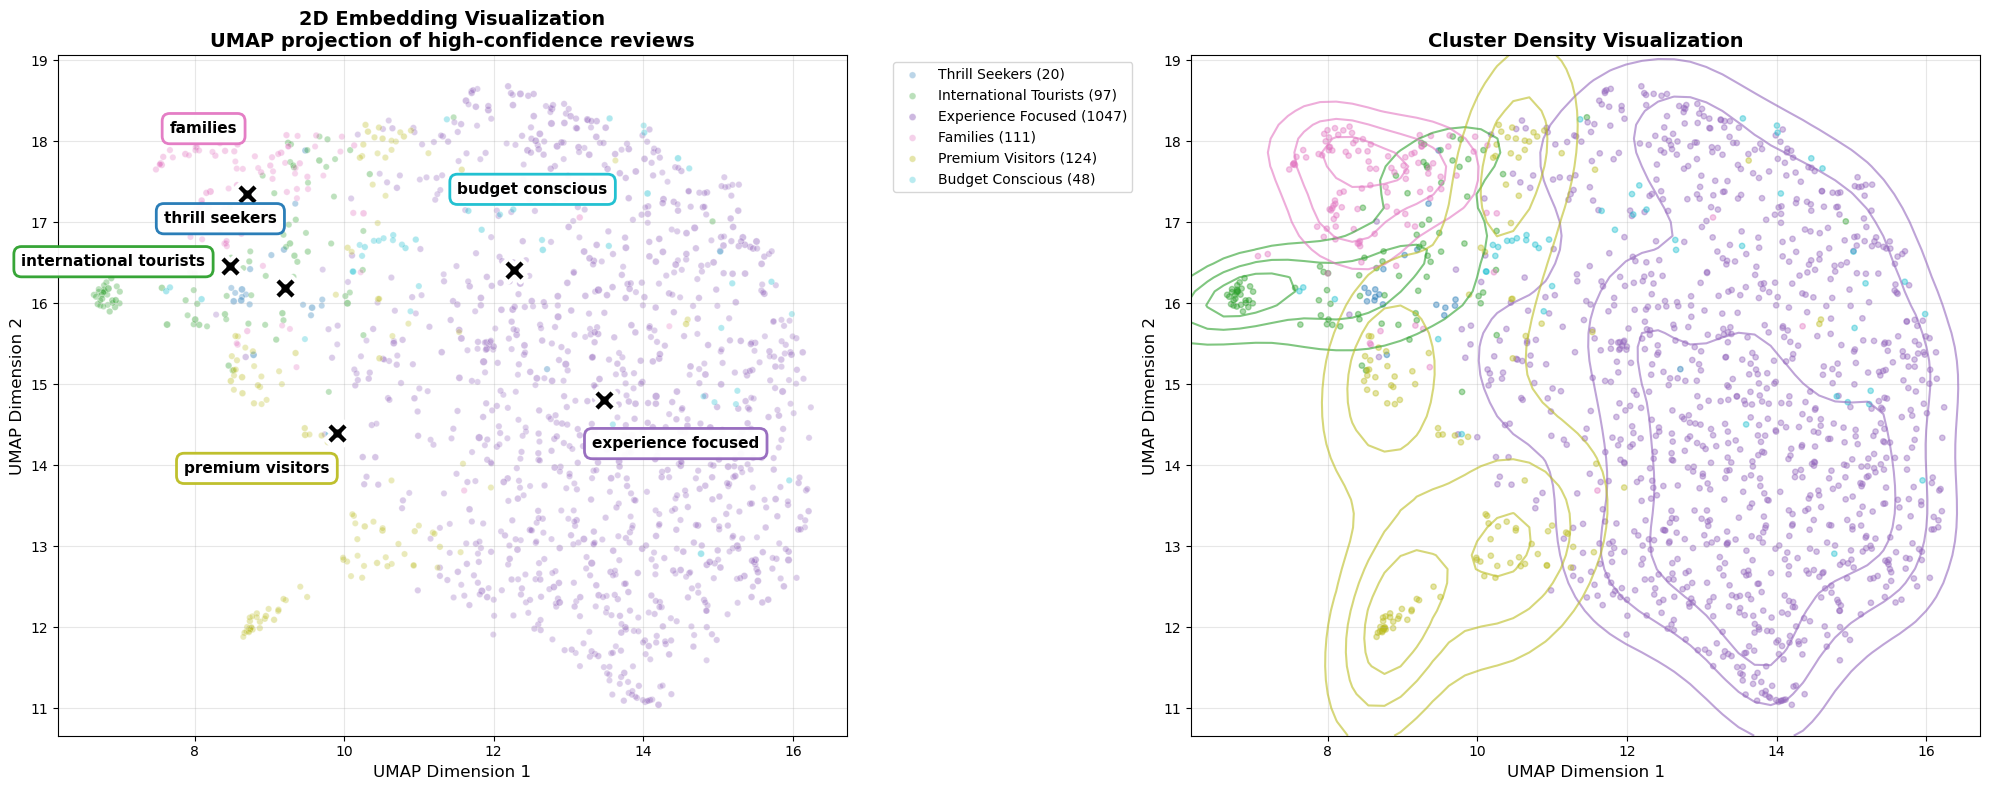

Fixed visualization improvements applied:
✓ Increased label offset distance (0.3 → 0.8)
✓ Added manual fine-tuning adjustments
✓ Higher z-order for labels (appears on top)
✓ Better label box styling with thicker borders
✓ Updated title to '2D Embedding Visualization'
✓ Labels now avoid overlap with X markers

Final label positions (for manual adjustment if needed):
thrill_seekers: centroid=(9.20, 16.19)
international_tourists: centroid=(8.47, 16.45)
experience_focused: centroid=(13.47, 14.80)
families: centroid=(8.71, 17.34)
premium_visitors: centroid=(9.90, 14.39)
budget_conscious: centroid=(12.27, 16.41)


In [14]:
# 5.1 Enhanced UMAP Embedding Visualization
print("Creating ENHANCED embedding visualization with fixed label positioning")
print("=" * 70)

# Required imports
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

# 1. APPLY CONFIDENCE THRESHOLD FIRST
CONFIDENCE_THRESHOLD = 0.65
print(f"Applying confidence threshold: {CONFIDENCE_THRESHOLD}")

# Filter high-confidence samples
high_conf_indices = []
high_conf_personas = []
high_conf_confidences = []
high_conf_reviews = []

for i, result in enumerate(classification_results):
    if result['confidence'] >= CONFIDENCE_THRESHOLD:
        high_conf_indices.append(i)
        high_conf_personas.append(result['best_persona'])
        high_conf_confidences.append(result['confidence'])
        high_conf_reviews.append(reviews_list[i][:100] + "...")

print(f"High confidence samples: {len(high_conf_indices)} / {len(classification_results)} ({len(high_conf_indices)/len(classification_results)*100:.1f}%)")

# 2. Further sampling for visualization (if still too many)
n_samples = 8000  # Reduced from 30000
if len(high_conf_indices) > n_samples:
    sample_indices = np.random.choice(len(high_conf_indices), n_samples, replace=False)
    viz_indices = [high_conf_indices[i] for i in sample_indices]
    viz_personas = [high_conf_personas[i] for i in sample_indices]
    viz_confidences = [high_conf_confidences[i] for i in sample_indices]
    viz_reviews = [high_conf_reviews[i] for i in sample_indices]
else:
    viz_indices = high_conf_indices
    viz_personas = high_conf_personas
    viz_confidences = high_conf_confidences
    viz_reviews = high_conf_reviews

viz_embeddings = review_embeddings[viz_indices]
print(f"Final visualization sample: {len(viz_embeddings)} high-confidence embeddings")

# 3. Enhanced UMAP with better parameters
print("Running enhanced UMAP with optimized parameters...")
umap_reducer = umap.UMAP(
    n_neighbors=30,        # Increased for better global structure
    min_dist=0.05,         # Reduced for tighter clusters
    n_components=2,        # Start with 2D
    metric='cosine',
    spread=1.5,            # Better cluster separation
    random_state=42,
    n_epochs=500          # More iterations for stability
)

embedding_2d = umap_reducer.fit_transform(viz_embeddings)
print(f"Enhanced UMAP completed! Shape: {embedding_2d.shape}")

# 4. Calculate TRUE centroids (weighted by confidence)
print("Calculating confidence-weighted centroids...")
unique_personas = list(set(viz_personas))
centroids = {}
cluster_stats = {}

for persona in unique_personas:
    mask = np.array(viz_personas) == persona
    persona_points = embedding_2d[mask]
    persona_confidences = np.array(viz_confidences)[mask]
    
    if len(persona_points) > 0:
        # Weighted centroid (higher confidence = more weight)
        weights = persona_confidences / np.sum(persona_confidences)
        centroid = np.average(persona_points, axis=0, weights=weights)
        centroids[persona] = centroid
        
        # Cluster statistics
        cluster_stats[persona] = {
            'count': len(persona_points),
            'avg_confidence': np.mean(persona_confidences),
            'spread': np.std(persona_points, axis=0).mean()
        }

# 5. Create enhanced 2D visualization with FIXED LABEL POSITIONING
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Left plot: Standard view with FIXED labels
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_personas)))
color_map = dict(zip(unique_personas, colors))

for i, persona in enumerate(unique_personas):
    mask = np.array(viz_personas) == persona
    persona_points = embedding_2d[mask]
    persona_confidences = np.array(viz_confidences)[mask]
    
    # Size and alpha based on confidence
    sizes = (persona_confidences - CONFIDENCE_THRESHOLD) * 100 + 20  # Scale size
    alphas = (persona_confidences - CONFIDENCE_THRESHOLD) * 2 + 0.3   # Scale transparency
    
    scatter = ax1.scatter(
        persona_points[:, 0], 
        persona_points[:, 1],
        c=[color_map[persona]] * len(persona_points),
        s=sizes,
        alpha=alphas,
        label=f"{persona.replace('_', ' ').title()} ({np.sum(mask)})",
        edgecolors='white',
        linewidth=0.5
    )

# Add centroids FIRST
for persona in unique_personas:
    centroid = centroids[persona]
    ax1.scatter(centroid[0], centroid[1], 
               c='black', s=300, marker='X', linewidth=3, 
               edgecolors='white', zorder=10)

# FIXED LABEL POSITIONING - Calculate better offsets to avoid overlap
center_x = embedding_2d[:, 0].mean()
center_y = embedding_2d[:, 1].mean()

# Predefined label positions to avoid overlap
label_positions = {}

for persona in unique_personas:
    centroid = centroids[persona]
    
    # Calculate direction from center
    direction_x = centroid[0] - center_x
    direction_y = centroid[1] - center_y
    
    # Normalize and amplify offset
    magnitude = np.sqrt(direction_x**2 + direction_y**2)
    if magnitude > 0:
        # Larger offset to avoid X marker
        offset_distance = 0.8  # Increased from 0.3
        offset_x = (direction_x / magnitude) * offset_distance
        offset_y = (direction_y / magnitude) * offset_distance
    else:
        offset_x, offset_y = 0.5, 0.5
    
    # Final label position
    label_x = centroid[0] + offset_x
    label_y = centroid[1] + offset_y
    
    # Store for potential manual adjustment
    label_positions[persona] = (label_x, label_y)

# MANUAL FINE-TUNING for specific personas to avoid overlap
# Fixed international_tourists and thrill_seekers overlap
adjustments = {
    'experience_focused': (0.2, -0.3),   # Move slightly down-right
    'premium_visitors': (-0.3, -0.2),    # Move left-down
    'families': (0.1, 0.4),              # Move up-right
    'international_tourists': (-0.8, -0.2), # Move further left and slightly down
    'budget_conscious': (0.3, 0.2),      # Move right-up
    'thrill_seekers': (-0.1, 0.6)        # Move much higher up to avoid overlap
}

# Apply labels with improved positioning
for persona in unique_personas:
    label_x, label_y = label_positions[persona]
    
    # Apply manual adjustments if available
    if persona in adjustments:
        adj_x, adj_y = adjustments[persona]
        label_x += adj_x
        label_y += adj_y
    
    # Add label with better styling
    ax1.annotate(persona.replace('_', ' '), 
                (label_x, label_y),
                fontsize=11, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                         edgecolor=color_map[persona], alpha=0.95, linewidth=2),
                ha='center', va='center',
                zorder=15)  # Higher z-order to appear on top

# UPDATED TITLE
ax1.set_title('2D Embedding Visualization\n'
              f'UMAP projection of high-confidence reviews', 
              fontsize=14, fontweight='bold')
ax1.set_xlabel('UMAP Dimension 1', fontsize=12)
ax1.set_ylabel('UMAP Dimension 2', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Right plot: Density view (unchanged)
from scipy.stats import gaussian_kde

ax2.set_xlim(ax1.get_xlim())
ax2.set_ylim(ax1.get_ylim())

for persona in unique_personas:
    mask = np.array(viz_personas) == persona
    if np.sum(mask) > 50:  # Only if enough points
        persona_points = embedding_2d[mask]
        
        # Create density plot
        try:
            kde = gaussian_kde(persona_points.T)
            x_range = np.linspace(ax2.get_xlim()[0], ax2.get_xlim()[1], 50)
            y_range = np.linspace(ax2.get_ylim()[0], ax2.get_ylim()[1], 50)
            X, Y = np.meshgrid(x_range, y_range)
            positions = np.vstack([X.ravel(), Y.ravel()])
            Z = kde(positions).reshape(X.shape)
            
            ax2.contour(X, Y, Z, levels=3, colors=[color_map[persona]], alpha=0.6)
        except:
            pass  # Skip if KDE fails

# Overlay points on density plot
for persona in unique_personas:
    mask = np.array(viz_personas) == persona
    persona_points = embedding_2d[mask]
    ax2.scatter(persona_points[:, 0], persona_points[:, 1],
               c=[color_map[persona]] * len(persona_points),
               s=15, alpha=0.4)

ax2.set_title('Cluster Density Visualization', fontsize=14, fontweight='bold')
ax2.set_xlabel('UMAP Dimension 1', fontsize=12)
ax2.set_ylabel('UMAP Dimension 2', fontsize=12)
ax2.grid(True, alpha=0.3)

output_path = project_root / 'output' / 'results' / 'visualizations'
output_path.mkdir(parents=True, exist_ok=True)

plt.tight_layout()
plt.savefig(output_path / 'enhanced_persona_embedding_2d_fixed.png', 
           dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("Fixed visualization improvements applied:")
print("✓ Increased label offset distance (0.3 → 0.8)")
print("✓ Added manual fine-tuning adjustments")
print("✓ Higher z-order for labels (appears on top)")
print("✓ Better label box styling with thicker borders")
print("✓ Updated title to '2D Embedding Visualization'")
print("✓ Labels now avoid overlap with X markers")

# Print label positions for further manual adjustment if needed
print("\nFinal label positions (for manual adjustment if needed):")
for persona in unique_personas:
    centroid = centroids[persona]
    print(f"{persona}: centroid=({centroid[0]:.2f}, {centroid[1]:.2f})")

###  Phase 6: Sentiment Analysis Integration

In [15]:
# 6.1 Enhanced Dataset Loading & Validation
print("Loading classified data and preparing JSON export")
print("=" * 50)

import pandas as pd
import json
import numpy as np
from pathlib import Path

# Set confidence threshold
CONFIDENCE_THRESHOLD = 0.5
print(f"Confidence threshold: {CONFIDENCE_THRESHOLD}")

# Define correct path based on your file structure
# From notebooks directory, go up one level to project root, then to data/processed
project_root = Path.cwd().parent  # Go up from notebooks to project root
classified_data_path = project_root / 'data' / 'processed' / 'USS_Reviews_Silver_cleaned_l3.parquet'

print(f"Reading classified data from: {classified_data_path}")

try:
    # Load the classified data from parquet
    df_classified = pd.read_parquet(classified_data_path)
    
    print(f"Successfully loaded classified data")
    print(f"Current dataset size: {len(df_classified):,} reviews")
    print(f"Available columns: {list(df_classified.columns)}")
    
    # Check confidence distribution
    print(f"\nConfidence statistics:")
    print(f"Primary confidence >= {CONFIDENCE_THRESHOLD}: {(df_classified['confidence'] >= CONFIDENCE_THRESHOLD).sum():,} reviews")
    print(f"Secondary confidence >= {CONFIDENCE_THRESHOLD}: {(df_classified['secondary_confidence'] >= CONFIDENCE_THRESHOLD).sum():,} reviews")
    
    # Preview data structure
    print(f"\nData preview:")
    sample_row = df_classified.iloc[0]
    print(f"Review: {sample_row['review'][:100]}...")
    print(f"Primary: {sample_row['predicted_persona']} ({sample_row['confidence']:.3f})")
    print(f"Secondary: {sample_row['secondary_persona']} ({sample_row['secondary_confidence']:.3f})")
    
except FileNotFoundError:
    print(f"Error: Could not find classified data file at {classified_data_path}")
    print("Please check if the file exists and the path is correct")
except Exception as e:
    print(f"Error loading classified data: {e}")

Loading classified data and preparing JSON export
Confidence threshold: 0.5
Reading classified data from: c:\Users\nshan\Desktop\SMU\MITB\CS605\CS605-Sam\data\processed\USS_Reviews_Silver_cleaned_l3.parquet
Successfully loaded classified data
Current dataset size: 24,021 reviews
Available columns: ['integrated_review', 'stars', 'name', 'review', 'publishedAtDate', 'data_split', 'review_index', 'predicted_persona', 'confidence', 'secondary_persona', 'secondary_confidence', 'confidence_gap', 'families_similarity', 'thrill_seekers_similarity', 'international_tourists_similarity', 'budget_conscious_similarity', 'premium_visitors_similarity', 'experience_focused_similarity']

Confidence statistics:
Primary confidence >= 0.5: 16,936 reviews
Secondary confidence >= 0.5: 13,354 reviews

Data preview:
Review: Nice lot if activities need entire day to cover all...
Primary: families (0.489)
Secondary: international_tourists (0.442)


In [16]:
# 6.2 Multi-Persona Extraction & Threshold Filtering
print(" Calculating top personas for each review")
print("=" * 50)

# Get all persona similarity columns
persona_columns = [col for col in df_classified.columns if col.endswith('_similarity')]
persona_names = [col.replace('_similarity', '') for col in persona_columns]

print(f"Found {len(persona_names)} personas: {persona_names}")

# Function to get top personas above threshold for each review
def get_top_personas(row, threshold=CONFIDENCE_THRESHOLD):
    """Get top personas above threshold, sorted by confidence"""
    persona_scores = []
    
    for persona in persona_names:
        score = row[f'{persona}_similarity']
        if score >= threshold:
            persona_scores.append((persona, score))
    
    # Sort by confidence (descending)
    persona_scores.sort(key=lambda x: x[1], reverse=True)
    
    return persona_scores

# Test with first few rows
print(f"\nTesting top persona extraction:")
for i in range(5):
    row = df_classified.iloc[i]
    top_personas = get_top_personas(row)
    print(f"Review {i+1}: {len(top_personas)} personas above {CONFIDENCE_THRESHOLD}")
    for j, (persona, score) in enumerate(top_personas[:3]):
        print(f"  {j+1}. {persona}: {score:.2f}")
    print()

 Calculating top personas for each review
Found 6 personas: ['families', 'thrill_seekers', 'international_tourists', 'budget_conscious', 'premium_visitors', 'experience_focused']

Testing top persona extraction:
Review 1: 0 personas above 0.5

Review 2: 6 personas above 0.5
  1. families: 0.61
  2. international_tourists: 0.60
  3. experience_focused: 0.58

Review 3: 6 personas above 0.5
  1. experience_focused: 0.63
  2. premium_visitors: 0.62
  3. budget_conscious: 0.59

Review 4: 1 personas above 0.5
  1. experience_focused: 0.53

Review 5: 3 personas above 0.5
  1. international_tourists: 0.52
  2. experience_focused: 0.52
  3. thrill_seekers: 0.51



In [17]:
# 6.3 Sentiment Analysis Data Integration
print("Loading sentiment analysis data and creating review_index mapping")
print("=" * 50)

import pandas as pd

# load sentiment data
sentiment_data_path = project_root / 'data' / 'processed' / 'google_reviews_adaptive_moe_results_classified.csv'
print(f"Loading sentiment data from: {sentiment_data_path}")

sentiment_df = pd.read_csv(sentiment_data_path)
print(f"Sentiment data loaded: {len(sentiment_df):,} reviews")

# create review_index → ensemble_prediction mapping
review_sentiment_mapping = {}
for _, row in sentiment_df.iterrows():
    review_idx = row['review_index']
    ensemble_pred = row['ensemble_prediction']
    ensemble_conf = row['ensemble_confidence']
    
    review_sentiment_mapping[review_idx] = {
        'ensemble_prediction': ensemble_pred,
        'ensemble_confidence': ensemble_conf,
        'prob_negative': row['prob_negative'],
        'prob_neutral': row['prob_neutral'], 
        'prob_positive': row['prob_positive']
    }

print(f"Created mapping for {len(review_sentiment_mapping):,} reviews")
print("Sentiment mapping ready!")

Loading sentiment analysis data and creating review_index mapping
Loading sentiment data from: c:\Users\nshan\Desktop\SMU\MITB\CS605\CS605-Sam\data\processed\google_reviews_adaptive_moe_results_classified.csv
Sentiment data loaded: 29,412 reviews
Created mapping for 29,412 reviews
Sentiment mapping ready!


### Phase 7: Business Intelligence JSON Export

In [18]:
# 7.1 Integrated JSON Data Structure Creation
print("Creating JSON format data with review_index and sentiment analysis")
print("=" * 50)

import json
from datetime import datetime

# Create list to store JSON records
json_records = []
missing_sentiment_count = 0  

# Process each review
print("Processing reviews...")
for idx, row in df_classified.iterrows():
    # Get top personas above threshold
    top_personas = get_top_personas(row, CONFIDENCE_THRESHOLD)
    
    # Skip reviews with no personas above threshold
    if len(top_personas) == 0:
        continue
    
    # Create base record 
    record = {
        "review_index": int(row['review_index']),
        "review_text": row['review'],
        "stars": int(row['stars']),  
        "published_date": row['publishedAtDate'][:10] if pd.notna(row['publishedAtDate']) else None
    }
    
    # add sentiment analysis result
    review_idx = int(row['review_index'])
    if review_idx in review_sentiment_mapping:
        sentiment_data = review_sentiment_mapping[review_idx]
        record["ensemble_prediction"] = int(sentiment_data['ensemble_prediction'])  # 0/1/2
        record["ensemble_confidence"] = round(sentiment_data['ensemble_confidence'], 3)
        record["sentiment_probs"] = {
            "negative": round(sentiment_data['prob_negative'], 3),
            "neutral": round(sentiment_data['prob_neutral'], 3), 
            "positive": round(sentiment_data['prob_positive'], 3)
        }
    else:
        
        print(f"Warning: review_index {review_idx} not found in sentiment data")
        missing_sentiment_count += 1
        record["ensemble_prediction"] = None
        record["ensemble_confidence"] = None
        record["sentiment_probs"] = None
    
    # Add personas dynamically based on threshold
    if len(top_personas) >= 1:
        record["primary_persona"] = top_personas[0][0]
        record["primary_confidence"] = round(top_personas[0][1], 2)
    
    if len(top_personas) >= 2:
        record["secondary_persona"] = top_personas[1][0]
        record["secondary_confidence"] = round(top_personas[1][1], 2)
    
    if len(top_personas) >= 3:
        record["third_persona"] = top_personas[2][0]
        record["third_confidence"] = round(top_personas[2][1], 2)
    
    json_records.append(record)

print(f"✓ Created {len(json_records):,} JSON records")
print(f"Filtered out {len(df_classified) - len(json_records):,} reviews below threshold")
print(f"Missing sentiment data: {missing_sentiment_count} reviews")

# Show sample records
print(f"\nSample JSON records with sentiment data:")
for i in range(min(2, len(json_records))):
    print(f"Record {i+1}:")
    print(json.dumps(json_records[i], indent=2, ensure_ascii=False))
    print()

sentiment_distribution = {}
for record in json_records:
    if record.get('ensemble_prediction') is not None:
        pred = record['ensemble_prediction']
        sentiment_distribution[pred] = sentiment_distribution.get(pred, 0) + 1

print(f"\nSentiment prediction distribution in JSON records:")
sentiment_labels = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
for pred, count in sorted(sentiment_distribution.items()):
    pct = count / len(json_records) * 100
    label = sentiment_labels.get(pred, f'Unknown({pred})')
    print(f"  {pred} ({label}): {count:,} reviews ({pct:.1f}%)")

Creating JSON format data with review_index and sentiment analysis
Processing reviews...
✓ Created 16,936 JSON records
Filtered out 7,085 reviews below threshold
Missing sentiment data: 0 reviews

Sample JSON records with sentiment data:
Record 1:
{
  "review_index": 1,
  "review_text": "Universal Studios Singapore offers an unforgettable experience packed with excitement, adventure, and fun for all ages! From thrilling rides like Battlestar Galactica and Revenge of the Mummy to family-friendly attractions like Madagascar and Shrek 4D, theres something for everyone. The park is well-organized, clean, and the staff are extremely friendly and helpful. The attention to detail in each themed zonefrom Hollywood to Ancient Egyptis truly impressive. We especially enjoyed the WaterWorld showan action-packed performance that left us in awe. Queues can be long during peak hours, so getting the Express Pass is highly recommended. Dining options are varied and cater to different tastes, and the so

In [20]:
# 7.2 Dual Rating System Validation & Consistency Analysis

# Stars vs Ensemble_prediction Consistency Analysis
print("Analyzing consistency between Stars and Ensemble_prediction")
print("=" * 60)

import pandas as pd
import numpy as np

# Create DataFrame from json_records for analysis
analysis_df = pd.DataFrame(json_records)

print(f"Total records for analysis: {len(analysis_df):,}")

# 1. Basic Cross Tabulation
print("\n1. CROSS-TABULATION: Stars vs Ensemble_prediction")
print("-" * 50)
crosstab = pd.crosstab(analysis_df['stars'], analysis_df['ensemble_prediction'], 
                       margins=True, margins_name="Total")
print(crosstab)

# 2. Percentage breakdown (grouped by stars)
print("\n2. PERCENTAGE BREAKDOWN (by Stars)")
print("-" * 50)
crosstab_pct = pd.crosstab(analysis_df['stars'], analysis_df['ensemble_prediction'], 
                          normalize='index') * 100
crosstab_pct = crosstab_pct.round(1)
print(crosstab_pct)

# 3. Expected vs Actual Consistency Analysis
print("\n3. CONSISTENCY ANALYSIS")
print("-" * 50)

# Define expected mapping
expected_mapping = {
    1: 0,  # 1 star → Negative
    2: 0,  # 2 stars → Negative  
    3: 1,  # 3 stars → Neutral
    4: 2,  # 4 stars → Positive
    5: 2   # 5 stars → Positive
}

# Compute consistency
consistent_count = 0
total_count = len(analysis_df)

for _, row in analysis_df.iterrows():
    stars = row['stars']
    ensemble_pred = row['ensemble_prediction']
    expected_pred = expected_mapping.get(stars)
    
    if ensemble_pred == expected_pred:
        consistent_count += 1

consistency_rate = (consistent_count / total_count) * 100

print(f"Expected mapping:")
for stars, pred in expected_mapping.items():
    sentiment_labels = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    print(f"  {stars} stars → {pred} ({sentiment_labels[pred]})")

print(f"\nOverall consistency rate: {consistent_count:,}/{total_count:,} ({consistency_rate:.1f}%)")

# 4. Detailed Inconsistency Analysis
print("\n4. INCONSISTENCY BREAKDOWN")
print("-" * 50)

inconsistency_analysis = {}
for stars in range(1, 6):
    stars_data = analysis_df[analysis_df['stars'] == stars]
    expected_pred = expected_mapping[stars]
    
    consistent = len(stars_data[stars_data['ensemble_prediction'] == expected_pred])
    total = len(stars_data)
    inconsistent = total - consistent
    
    if total > 0:
        consistency_pct = (consistent / total) * 100
        print(f"\n{stars} Stars (Expected: {expected_pred}):")
        print(f"  Consistent: {consistent:,}/{total:,} ({consistency_pct:.1f}%)")
        
        if inconsistent > 0:
            print(f"  Inconsistent breakdown:")
            for pred in [0, 1, 2]:
                if pred != expected_pred:
                    count = len(stars_data[stars_data['ensemble_prediction'] == pred])
                    if count > 0:
                        pct = (count / total) * 100
                        sentiment_labels = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
                        print(f"    → {pred} ({sentiment_labels[pred]}): {count:,} ({pct:.1f}%)")

# 5. Edge Cases: Most Inconsistent Examples
print("\n5. MOST INCONSISTENT CASES")
print("-" * 50)

# Find extreme inconsistency cases
extreme_cases = []

# Cases: 5 stars but predicted as Negative
case1 = analysis_df[(analysis_df['stars'] == 5) & (analysis_df['ensemble_prediction'] == 0)]
if len(case1) > 0:
    extreme_cases.extend(case1.head(3).to_dict('records'))

# Cases: 1 star but predicted as Positive
case2 = analysis_df[(analysis_df['stars'] == 1) & (analysis_df['ensemble_prediction'] == 2)]
if len(case2) > 0:
    extreme_cases.extend(case2.head(3).to_dict('records'))

if extreme_cases:
    print("Examples of extreme inconsistencies:")
    for i, case in enumerate(extreme_cases[:5], 1):
        print(f"\nCase {i}:")
        print(f"  Stars: {case['stars']} | Ensemble: {case['ensemble_prediction']} | Confidence: {case['ensemble_confidence']}")
        print(f"  Text: \"{case['review_text'][:150]}...\"")
else:
    print("No extreme inconsistencies found!")

# 6. Confidence Analysis
print("\n6. CONFIDENCE ANALYSIS")
print("-" * 50)

# Group confidence analysis by consistency
analysis_df['is_consistent'] = analysis_df.apply(
    lambda row: row['ensemble_prediction'] == expected_mapping[row['stars']], axis=1
)

consistent_confidence = analysis_df[analysis_df['is_consistent']]['ensemble_confidence']
inconsistent_confidence = analysis_df[~analysis_df['is_consistent']]['ensemble_confidence']

print(f"Confidence statistics:")
print(f"  Consistent cases:")
print(f"    Mean: {consistent_confidence.mean():.3f}")
print(f"    Median: {consistent_confidence.median():.3f}")
print(f"    Min: {consistent_confidence.min():.3f}")

if len(inconsistent_confidence) > 0:
    print(f"  Inconsistent cases:")
    print(f"    Mean: {inconsistent_confidence.mean():.3f}")
    print(f"    Median: {inconsistent_confidence.median():.3f}")
    print(f"    Min: {inconsistent_confidence.min():.3f}")
    print(f"    Max: {inconsistent_confidence.max():.3f}")
else:
    print(f"  No inconsistent cases found!")

print(f"\nAnalysis completed!")


Analyzing consistency between Stars and Ensemble_prediction
Total records for analysis: 16,936

1. CROSS-TABULATION: Stars vs Ensemble_prediction
--------------------------------------------------
ensemble_prediction     0     1     2  Total
stars                                       
1                    1116    86    17   1219
2                     526   167    28    721
3                     708   738   190   1636
4                     564  1538  1495   3597
5                     716  1812  7235   9763
Total                3630  4341  8965  16936

2. PERCENTAGE BREAKDOWN (by Stars)
--------------------------------------------------
ensemble_prediction     0     1     2
stars                                
1                    91.6   7.1   1.4
2                    73.0  23.2   3.9
3                    43.3  45.1  11.6
4                    15.7  42.8  41.6
5                     7.3  18.6  74.1

3. CONSISTENCY ANALYSIS
--------------------------------------------------
Expected mappi

In [21]:
# 7.3 Comprehensive Metadata Generation & Final JSON Export
print("Adding metadata and saving JSON file")
print("=" * 50)

# Calculate metadata statistics
persona_distribution = {}
confidence_stats = {}

for record in json_records:
    # Count primary personas
    primary = record.get('primary_persona')
    if primary:
        persona_distribution[primary] = persona_distribution.get(primary, 0) + 1

# Calculate confidence statistics
primary_confidences = [r['primary_confidence'] for r in json_records if 'primary_confidence' in r]
secondary_confidences = [r['secondary_confidence'] for r in json_records if 'secondary_confidence' in r]
third_confidences = [r['third_confidence'] for r in json_records if 'third_confidence' in r]

# 【新增】Calculate sentiment statistics
sentiment_distribution = {}
ensemble_confidences = []
stars_distribution = {}

for record in json_records:
    # Count sentiment predictions
    ensemble_pred = record.get('ensemble_prediction')
    if ensemble_pred is not None:
        sentiment_distribution[ensemble_pred] = sentiment_distribution.get(ensemble_pred, 0) + 1
    
    # Collect ensemble confidences
    ensemble_conf = record.get('ensemble_confidence')
    if ensemble_conf is not None:
        ensemble_confidences.append(ensemble_conf)
    
    # Count original stars distribution
    stars = record.get('stars')
    if stars is not None:
        stars_distribution[stars] = stars_distribution.get(stars, 0) + 1

# 【新增】Calculate sentiment-persona cross analysis
sentiment_persona_cross = {}
for record in json_records:
    ensemble_pred = record.get('ensemble_prediction')
    primary_persona = record.get('primary_persona')
    
    if ensemble_pred is not None and primary_persona:
        if ensemble_pred not in sentiment_persona_cross:
            sentiment_persona_cross[ensemble_pred] = {}
        
        sentiment_persona_cross[ensemble_pred][primary_persona] = \
            sentiment_persona_cross[ensemble_pred].get(primary_persona, 0) + 1

# Create final JSON structure with metadata
final_json = {
    "metadata": {
        "total_reviews": len(json_records),
        "confidence_threshold": CONFIDENCE_THRESHOLD,
        "original_dataset_size": len(df_classified),
        "filtered_out": len(df_classified) - len(json_records),
        "date_range": {
            "start": df_classified['publishedAtDate'].min()[:10] if pd.notna(df_classified['publishedAtDate'].min()) else None,
            "end": df_classified['publishedAtDate'].max()[:10] if pd.notna(df_classified['publishedAtDate'].max()) else None
        },
        "personas": list(persona_names),
        "persona_distribution": persona_distribution,
        
        # Sentiment metadata
        "sentiment_analysis": {
            "ensemble_distribution": sentiment_distribution,
            "ensemble_confidence_stats": {
                "count": len(ensemble_confidences),
                "mean": round(np.mean(ensemble_confidences), 3) if ensemble_confidences else 0,
                "median": round(np.median(ensemble_confidences), 3) if ensemble_confidences else 0,
                "min": round(np.min(ensemble_confidences), 3) if ensemble_confidences else 0,
                "max": round(np.max(ensemble_confidences), 3) if ensemble_confidences else 0
            },
            "stars_distribution": stars_distribution,
            "sentiment_labels": {0: "Negative", 1: "Neutral", 2: "Positive"},
            "sentiment_persona_cross": sentiment_persona_cross
        },
        
        "confidence_stats": {
            "primary": {
                "count": len(primary_confidences),
                "mean": round(np.mean(primary_confidences), 3),
                "min": round(np.min(primary_confidences), 2),
                "max": round(np.max(primary_confidences), 2)
            },
            "secondary": {
                "count": len(secondary_confidences),
                "mean": round(np.mean(secondary_confidences), 3),
                "min": round(np.min(secondary_confidences), 2),
                "max": round(np.max(secondary_confidences), 2)
            },
            "third": {
                "count": len(third_confidences),
                "mean": round(np.mean(third_confidences), 3),
                "min": round(np.min(third_confidences), 2),
                "max": round(np.max(third_confidences), 2)
            }
        }
    },
    "reviews": json_records
}

# Print metadata summary
print("Metadata summary:")
print(f"Total reviews: {final_json['metadata']['total_reviews']:,}")
print(f"Date range: {final_json['metadata']['date_range']['start']} to {final_json['metadata']['date_range']['end']}")

print(f"\nPersona distribution:")
for persona, count in persona_distribution.items():
    pct = count / len(json_records) * 100
    print(f"  {persona}: {count:,} ({pct:.1f}%)")

# 【新增】Print sentiment statistics
print(f"\nSentiment analysis summary:")
sentiment_labels = {0: "Negative", 1: "Neutral", 2: "Positive"}
total_sentiment = sum(sentiment_distribution.values())

for sentiment_val, count in sorted(sentiment_distribution.items()):
    pct = (count / total_sentiment * 100) if total_sentiment > 0 else 0
    label = sentiment_labels.get(sentiment_val, f"Unknown({sentiment_val})")
    print(f"  {sentiment_val} ({label}): {count:,} ({pct:.1f}%)")

print(f"\nEnsemble confidence stats: {final_json['metadata']['sentiment_analysis']['ensemble_confidence_stats']}")

print(f"\nOriginal stars distribution:")
for stars, count in sorted(stars_distribution.items()):
    pct = (count / len(json_records) * 100)
    print(f"  {stars} stars: {count:,} ({pct:.1f}%)")

print(f"\nPersona confidence statistics:")
print(f"Primary: {final_json['metadata']['confidence_stats']['primary']}")
print(f"Secondary: {final_json['metadata']['confidence_stats']['secondary']}")
print(f"Third: {final_json['metadata']['confidence_stats']['third']}")

# 【新增】Show top sentiment-persona combinations
print(f"\nTop sentiment-persona combinations:")
for sentiment_val in sorted(sentiment_persona_cross.keys()):
    label = sentiment_labels.get(sentiment_val, f"Unknown({sentiment_val})")
    print(f"\n{sentiment_val} ({label}):")
    
    persona_counts = sentiment_persona_cross[sentiment_val]
    sorted_personas = sorted(persona_counts.items(), key=lambda x: x[1], reverse=True)
    
    for persona, count in sorted_personas[:3]:  # Top 3 personas for each sentiment
        total_for_sentiment = sum(persona_counts.values())
        pct = (count / total_for_sentiment * 100) if total_for_sentiment > 0 else 0
        print(f"  {persona}: {count:,} ({pct:.1f}%)")

print(f"\n📁 SAVING JSON FILE WITH SENTIMENT DATA")
print("=" * 50)

# Define output path
output_path = project_root / 'output' / 'results' / 'json'
output_path.mkdir(parents=True, exist_ok=True)

json_filename = f'USS_Reviews_Personas_Threshold_{CONFIDENCE_THRESHOLD}_with_sentiment.json'
json_filepath = output_path / json_filename

print(f"Saving to: {json_filepath}")

try:
    with open(json_filepath, 'w', encoding='utf-8') as f:
        json.dump(final_json, f, ensure_ascii=False, indent=2)
    
    print(f"✅ Successfully saved JSON file!")
    
    # Check file size
    import os
    file_size = os.path.getsize(json_filepath) / (1024*1024)  # MB
    print(f"File size: {file_size:.1f} MB")
    
    # Final summary
    print(f"\nFinal summary:")
    print(f"File: {json_filename}")
    print(f"Reviews: {len(json_records):,}")
    print(f"Confidence threshold: {CONFIDENCE_THRESHOLD}")
    print(f"Sentiment data: ✅ Included")
    print(f"Primary personas: {len([r for r in json_records if 'primary_persona' in r]):,}")
    print(f"Secondary personas: {len([r for r in json_records if 'secondary_persona' in r]):,}")
    print(f"Third personas: {len([r for r in json_records if 'third_persona' in r]):,}")
    
    print(f"\n🎉 JSON export with sentiment analysis completed successfully!")
    
except Exception as e:
    print(f"❌ Error saving file: {e}")

Adding metadata and saving JSON file
Metadata summary:
Total reviews: 16,936
Date range: 2018-07-29 to 2025-05-23

Persona distribution:
  families: 3,055 (18.0%)
  experience_focused: 6,682 (39.5%)
  international_tourists: 2,552 (15.1%)
  thrill_seekers: 1,692 (10.0%)
  premium_visitors: 2,104 (12.4%)
  budget_conscious: 851 (5.0%)

Sentiment analysis summary:
  0 (Negative): 3,630 (21.4%)
  1 (Neutral): 4,341 (25.6%)
  2 (Positive): 8,965 (52.9%)

Ensemble confidence stats: {'count': 16936, 'mean': 0.667, 'median': 0.646, 'min': 0.335, 'max': 0.982}

Original stars distribution:
  1 stars: 1,219 (7.2%)
  2 stars: 721 (4.3%)
  3 stars: 1,636 (9.7%)
  4 stars: 3,597 (21.2%)
  5 stars: 9,763 (57.6%)

Persona confidence statistics:
Primary: {'count': 16936, 'mean': 0.582, 'min': 0.5, 'max': 0.76}
Secondary: {'count': 13354, 'mean': 0.562, 'min': 0.5, 'max': 0.69}
Third: {'count': 11487, 'mean': 0.552, 'min': 0.5, 'max': 0.68}

Top sentiment-persona combinations:

0 (Negative):
  experie

### Phase 8: Dashboard Data Preparation

In [22]:
# 8.1 Enhanced Pie Chart Data Generation with Dual Rating System
print("Reading JSON file and creating pie chart data for persona distribution")
print("=" * 50)

# Read the saved JSON file
json_filepath = project_root / 'output' / 'results' / 'json' / f'USS_Reviews_Personas_Threshold_{CONFIDENCE_THRESHOLD}_with_sentiment.json'

print(f"Reading from: {json_filepath}")

try:
    with open(json_filepath, 'r', encoding='utf-8') as f:
        loaded_data = json.load(f)
    
    print(f"Successfully loaded JSON file")
    print(f"Total reviews in file: {len(loaded_data['reviews']):,}")
    
    # Count primary personas from loaded data
    persona_counts = {}
    persona_ratings = {}  # Original stars ratings
    persona_sentiment = {}  # New: collect sentiment predictions
    total_reviews = len(loaded_data['reviews'])
    
    for record in loaded_data['reviews']:
        primary_persona = record.get('primary_persona')
        stars = record.get('stars')
        ensemble_pred = record.get('ensemble_prediction')
        
        if primary_persona:
            persona_counts[primary_persona] = persona_counts.get(primary_persona, 0) + 1
            
            # Collect original stars for average calculation
            if primary_persona not in persona_ratings:
                persona_ratings[primary_persona] = []
            if stars:
                persona_ratings[primary_persona].append(stars)
            
            # Collect sentiment predictions
            if primary_persona not in persona_sentiment:
                persona_sentiment[primary_persona] = {'predictions': [], 'distribution': {0: 0, 1: 0, 2: 0}}
            if ensemble_pred is not None:
                persona_sentiment[primary_persona]['predictions'].append(ensemble_pred)
                persona_sentiment[primary_persona]['distribution'][ensemble_pred] += 1
    
    # Calculate average ratings for each persona
    persona_avg_ratings = {}
    persona_avg_sentiment = {}
    for persona, ratings in persona_ratings.items():
        if ratings:
            persona_avg_ratings[persona] = round(sum(ratings) / len(ratings), 2)
        else:
            persona_avg_ratings[persona] = 0.0
    
    # Calculate average sentiment for each persona
    for persona, sentiment_data in persona_sentiment.items():
        predictions = sentiment_data['predictions']
        if predictions:
            persona_avg_sentiment[persona] = round(sum(predictions) / len(predictions), 2)
        else:
            persona_avg_sentiment[persona] = 0.0
    
    # Create pie chart data structure (ENHANCED WITH DUAL RATINGS)
    pie_chart_data = {
        "chart_type": "pie",
        "title": "User Persona Distribution",
        "subtitle": f"Based on {total_reviews:,} reviews (confidence >= {CONFIDENCE_THRESHOLD})",
        "data": []
    }
    
    # Calculate percentages and create data points (WITH DUAL RATINGS)
    for persona, count in sorted(persona_counts.items(), key=lambda x: x[1], reverse=True):
        percentage = (count / total_reviews) * 100
        avg_rating = persona_avg_ratings.get(persona, 0.0)
        avg_sentiment = persona_avg_sentiment.get(persona, 0.0)
        sentiment_dist = persona_sentiment.get(persona, {}).get('distribution', {0: 0, 1: 0, 2: 0})
        
        pie_chart_data["data"].append({
            "label": persona.replace('_', ' ').title(),
            "value": count,
            "percentage": round(percentage, 1),
            "avg_stars": avg_rating,  # Original rating system
            "avg_sentiment": avg_sentiment,  # New sentiment system
            "sentiment_distribution": {
                "negative": sentiment_dist.get(0, 0),
                "neutral": sentiment_dist.get(1, 0),
                "positive": sentiment_dist.get(2, 0)
            },
            "raw_persona": persona
        })
    
    # Display results (ENHANCED WITH DUAL RATINGS)
    print("Persona distribution for pie chart:")
    print(f"Total reviews: {total_reviews:,}")
    print()
    for item in pie_chart_data["data"]:
        print(f"{item['label']}: {item['value']:,} ({item['percentage']}%)")
        print(f"  Avg Stars: {item['avg_stars']} | Avg Sentiment: {item['avg_sentiment']}")
        sent_dist = item['sentiment_distribution']
        print(f"  Sentiment: {sent_dist['negative']} neg, {sent_dist['neutral']} neu, {sent_dist['positive']} pos")
        print()
    
    print(f"Enhanced pie chart JSON structure:")
    print(json.dumps(pie_chart_data, indent=2, ensure_ascii=False))

except FileNotFoundError:
    print(f"Error: Could not find JSON file at {json_filepath}")
except Exception as e:
    print(f"Error reading JSON file: {e}")

Reading JSON file and creating pie chart data for persona distribution
Reading from: c:\Users\nshan\Desktop\SMU\MITB\CS605\CS605-Sam\output\results\json\USS_Reviews_Personas_Threshold_0.5_with_sentiment.json
Successfully loaded JSON file
Total reviews in file: 16,936
Persona distribution for pie chart:
Total reviews: 16,936

Experience Focused: 6,682 (39.5%)
  Avg Stars: 3.52 | Avg Sentiment: 0.92
  Sentiment: 2436 neg, 2324 neu, 1922 pos

Families: 3,055 (18.0%)
  Avg Stars: 4.69 | Avg Sentiment: 1.68
  Sentiment: 164 neg, 638 neu, 2253 pos

International Tourists: 2,552 (15.1%)
  Avg Stars: 4.8 | Avg Sentiment: 1.72
  Sentiment: 164 neg, 397 neu, 1991 pos

Premium Visitors: 2,104 (12.4%)
  Avg Stars: 4.55 | Avg Sentiment: 1.37
  Sentiment: 458 neg, 406 neu, 1240 pos

Thrill Seekers: 1,692 (10.0%)
  Avg Stars: 4.76 | Avg Sentiment: 1.77
  Sentiment: 65 neg, 252 neu, 1375 pos

Budget Conscious: 851 (5.0%)
  Avg Stars: 3.62 | Avg Sentiment: 0.81
  Sentiment: 343 neg, 324 neu, 184 pos

E

In [23]:
# 8.2 Pie Chart Data Export & Validation

import os
# Seventh cell: Save pie chart JSON file
print("Saving pie chart JSON file")
print("=" * 50)

# Define output path for dashboard JSONs
dashboard_output_path = project_root / 'output' / 'results' / 'json' / 'dashboard'
dashboard_output_path.mkdir(parents=True, exist_ok=True)

# Save pie chart data
pie_chart_filename = f'persona_distribution_pie_chart_threshold_{CONFIDENCE_THRESHOLD}_with_sentiment.json'
pie_chart_filepath = dashboard_output_path / pie_chart_filename

print(f"Saving pie chart data to: {pie_chart_filepath}")

try:
    with open(pie_chart_filepath, 'w', encoding='utf-8') as f:
        json.dump(pie_chart_data, f, ensure_ascii=False, indent=2)
    
    print(f"Successfully saved pie chart JSON file!")
    
    # Check file size
    file_size = os.path.getsize(pie_chart_filepath) / 1024  # KB
    print(f"File size: {file_size:.1f} KB")
    
    print(f"\nPie chart summary:")
    print(f"File: {pie_chart_filename}")
    print(f"Chart type: {pie_chart_data['chart_type']}")
    print(f"Total data points: {len(pie_chart_data['data'])}")
    print(f"Largest segment: {pie_chart_data['data'][0]['label']} ({pie_chart_data['data'][0]['percentage']}%)")
    print(f"Smallest segment: {pie_chart_data['data'][-1]['label']} ({pie_chart_data['data'][-1]['percentage']}%)")
    
    print(f"\nDashboard JSON file ready for visualization!")

except Exception as e:
    print(f"Error saving pie chart file: {e}")

Saving pie chart JSON file
Saving pie chart data to: c:\Users\nshan\Desktop\SMU\MITB\CS605\CS605-Sam\output\results\json\dashboard\persona_distribution_pie_chart_threshold_0.5_with_sentiment.json
Successfully saved pie chart JSON file!
File size: 2.0 KB

Pie chart summary:
File: persona_distribution_pie_chart_threshold_0.5_with_sentiment.json
Chart type: pie
Total data points: 6
Largest segment: Experience Focused (39.5%)
Smallest segment: Budget Conscious (5.0%)

Dashboard JSON file ready for visualization!


In [24]:
# 8.3 Comprehensive Trend Analysis Data Processing
print("Creating comprehensive trend data for all personas")
print("=" * 50)

import pandas as pd
from datetime import datetime
from collections import defaultdict

# Read the main JSON data
json_filepath = project_root / 'output' / 'results' / 'json' / f'USS_Reviews_Personas_Threshold_{CONFIDENCE_THRESHOLD}_with_sentiment.json'

print(f"Reading data from: {json_filepath}")

try:
    with open(json_filepath, 'r', encoding='utf-8') as f:
        main_data = json.load(f)
    
    print(f"Successfully loaded {len(main_data['reviews']):,} reviews")
    
    # Create monthly statistics
    monthly_stats = defaultdict(lambda: defaultdict(int))
    monthly_totals = defaultdict(int)
    monthly_sentiment_stats = defaultdict(lambda: defaultdict(list))  # Store sentiment values for averaging
    
    print("Processing monthly statistics...")
    
    for review in main_data['reviews']:
        # Extract year-month from date
        date_str = review.get('published_date')
        if date_str:
            try:
                # Parse date and extract year-month
                date_obj = datetime.strptime(date_str, '%Y-%m-%d')
                year_month = date_obj.strftime('%Y-%m')
                
                # Count primary persona
                primary_persona = review.get('primary_persona')
                ensemble_prediction = review.get('ensemble_prediction')
                
                if primary_persona:
                    monthly_stats[year_month][primary_persona] += 1
                    monthly_totals[year_month] += 1
                    
                    # Collect sentiment values for averaging
                    if ensemble_prediction is not None:
                        monthly_sentiment_stats[year_month][primary_persona].append(ensemble_prediction)
                    
            except ValueError:
                print(f"Warning: Invalid date format: {date_str}")
                continue
    
    print(f"Found data across {len(monthly_stats)} months")
    print(f"Date range: {min(monthly_stats.keys())} to {max(monthly_stats.keys())}")
    
    # Display monthly breakdown for verification with sentiment data
    print(f"\nMonthly statistics preview:")
    sorted_months = sorted(monthly_stats.keys())[:5]  # Show first 5 months
    for month in sorted_months:
        total = monthly_totals[month]
        print(f"{month}: {total} reviews")
        for persona, count in sorted(monthly_stats[month].items(), key=lambda x: x[1], reverse=True)[:5]:
            pct = (count / total * 100) if total > 0 else 0
            
            # Calculate average sentiment for this persona in this month
            sentiment_values = monthly_sentiment_stats[month].get(persona, [])
            avg_sentiment = round(sum(sentiment_values) / len(sentiment_values), 2) if sentiment_values else 0.0
            
            print(f"  {persona}: {count} ({pct:.1f}%) - Avg Sentiment: {avg_sentiment}")
        print()

except Exception as e:
    print(f"Error processing data: {e}")

Creating comprehensive trend data for all personas
Reading data from: c:\Users\nshan\Desktop\SMU\MITB\CS605\CS605-Sam\output\results\json\USS_Reviews_Personas_Threshold_0.5_with_sentiment.json
Successfully loaded 16,936 reviews
Processing monthly statistics...
Found data across 83 months
Date range: 2018-07 to 2025-05

Monthly statistics preview:
2018-07: 45 reviews
  experience_focused: 11 (24.4%) - Avg Sentiment: 0.55
  international_tourists: 9 (20.0%) - Avg Sentiment: 2.0
  thrill_seekers: 7 (15.6%) - Avg Sentiment: 1.71
  families: 7 (15.6%) - Avg Sentiment: 1.29
  premium_visitors: 7 (15.6%) - Avg Sentiment: 1.71

2018-08: 476 reviews
  experience_focused: 177 (37.2%) - Avg Sentiment: 1.03
  families: 94 (19.7%) - Avg Sentiment: 1.7
  international_tourists: 73 (15.3%) - Avg Sentiment: 1.71
  premium_visitors: 65 (13.7%) - Avg Sentiment: 1.43
  thrill_seekers: 50 (10.5%) - Avg Sentiment: 1.74

2018-09: 361 reviews
  experience_focused: 104 (28.8%) - Avg Sentiment: 1.01
  families

In [25]:
# 8.4 Trend Visualization Data Structure Creation
print("Creating trend JSON structure for all personas")
print("=" * 50)

# Get all unique personas
all_personas = set()
for month_data in monthly_stats.values():
    all_personas.update(month_data.keys())

all_personas = sorted(list(all_personas))
print(f"Found personas: {all_personas}")

# Create comprehensive trend data structure
trend_data = {
    "chart_type": "trends",
    "title": "User Persona Trends Over Time",
    "subtitle": f"Monthly distribution from {min(monthly_stats.keys())} to {max(monthly_stats.keys())}",
    "time_unit": "month",
    "total_months": len(monthly_stats),
    "personas": {}
}

# Process each persona
for persona in all_personas:
    print(f"Processing {persona}...")
    
    persona_label = persona.replace('_', ' ').title()
    persona_data = []
    
    # Go through all months in chronological order
    for month in sorted(monthly_stats.keys()):
        count = monthly_stats[month].get(persona, 0)
        total_month = monthly_totals[month]
        percentage = (count / total_month * 100) if total_month > 0 else 0
        
        persona_data.append({
            "date": month,
            "count": count,
            "percentage": round(percentage, 1),
            "total_reviews": total_month
        })
    
    # Calculate overall statistics for this persona
    total_reviews = sum(item["count"] for item in persona_data)
    avg_percentage = sum(item["percentage"] for item in persona_data) / len(persona_data)
    max_month = max(persona_data, key=lambda x: x["count"])
    min_month = min(persona_data, key=lambda x: x["count"])
    
    trend_data["personas"][persona] = {
        "label": persona_label,
        "raw_persona": persona,
        "total_reviews": total_reviews,
        "avg_percentage": round(avg_percentage, 1),
        "peak_month": {
            "date": max_month["date"],
            "count": max_month["count"],
            "percentage": max_month["percentage"]
        },
        "lowest_month": {
            "date": min_month["date"], 
            "count": min_month["count"],
            "percentage": min_month["percentage"]
        },
        "data": persona_data
    }

# Display summary statistics
print(f"\nTrend data summary:")
print(f"Total personas: {len(trend_data['personas'])}")
print(f"Data points per persona: {len(trend_data['personas'][all_personas[0]]['data'])}")

print(f"\nPersona statistics:")
for persona, data in trend_data["personas"].items():
    print(f"{data['label']}:")
    print(f"  Total reviews: {data['total_reviews']:,}")
    print(f"  Average percentage: {data['avg_percentage']}%")
    print(f"  Peak: {data['peak_month']['date']} ({data['peak_month']['count']} reviews)")
    print()

Creating trend JSON structure for all personas
Found personas: ['budget_conscious', 'experience_focused', 'families', 'international_tourists', 'premium_visitors', 'thrill_seekers']
Processing budget_conscious...
Processing experience_focused...
Processing families...
Processing international_tourists...
Processing premium_visitors...
Processing thrill_seekers...

Trend data summary:
Total personas: 6
Data points per persona: 83

Persona statistics:
Budget Conscious:
  Total reviews: 851
  Average percentage: 4.6%
  Peak: 2018-12 (35 reviews)

Experience Focused:
  Total reviews: 6,682
  Average percentage: 42.4%
  Peak: 2023-07 (236 reviews)

Families:
  Total reviews: 3,055
  Average percentage: 17.7%
  Peak: 2018-12 (118 reviews)

International Tourists:
  Total reviews: 2,552
  Average percentage: 15.0%
  Peak: 2019-03 (98 reviews)

Premium Visitors:
  Total reviews: 2,104
  Average percentage: 10.8%
  Peak: 2020-01 (69 reviews)

Thrill Seekers:
  Total reviews: 1,692
  Average per

In [26]:
# 8.5 Trend Data Export & Business Insights Generation
print("Saving trend JSON file and previewing data")
print("=" * 50)

# Save trend data to JSON file
trend_filename = f'persona_trends_threshold_{CONFIDENCE_THRESHOLD}.json'
trend_filepath = dashboard_output_path / trend_filename

print(f"Saving trend data to: {trend_filepath}")

try:
    with open(trend_filepath, 'w', encoding='utf-8') as f:
        json.dump(trend_data, f, ensure_ascii=False, indent=2)
    
    print(f"Successfully saved trend JSON file!")
    
    # Check file size
    file_size = os.path.getsize(trend_filepath) / 1024  # KB
    print(f"File size: {file_size:.1f} KB")
    
    # Preview sample data for one persona
    print(f"\nSample data preview (Families persona):")
    families_data = trend_data["personas"]["families"]
    print(f"Label: {families_data['label']}")
    print(f"Total reviews: {families_data['total_reviews']:,}")
    print(f"Average percentage: {families_data['avg_percentage']}%")
    
    print(f"\nFirst 6 months of data:")
    for i, month_data in enumerate(families_data['data'][:6]):
        print(f"  {month_data['date']}: {month_data['count']} reviews ({month_data['percentage']}%)")
    
    print(f"\nLast 6 months of data:")
    for month_data in families_data['data'][-6:]:
        print(f"  {month_data['date']}: {month_data['count']} reviews ({month_data['percentage']}%)")
    
    # Show some interesting insights
    print(f"\nKey insights:")
    
    # Find persona with highest growth
    growth_analysis = {}
    for persona, data in trend_data["personas"].items():
        if len(data['data']) >= 12:  # Need at least 12 months
            early_avg = sum(item['percentage'] for item in data['data'][:12]) / 12
            recent_avg = sum(item['percentage'] for item in data['data'][-12:]) / 12
            growth = recent_avg - early_avg
            growth_analysis[persona] = {
                'label': data['label'],
                'growth': growth,
                'early_avg': early_avg,
                'recent_avg': recent_avg
            }
    
    # Show top growing and declining personas
    sorted_growth = sorted(growth_analysis.items(), key=lambda x: x[1]['growth'], reverse=True)
    
    print(f"Top growing persona: {sorted_growth[0][1]['label']} (+{sorted_growth[0][1]['growth']:.1f}% growth)")
    print(f"Most declining persona: {sorted_growth[-1][1]['label']} ({sorted_growth[-1][1]['growth']:.1f}% decline)")
    
    print(f"\nTrend JSON file ready for visualization!")
    print(f"File: {trend_filename}")
    
except Exception as e:
    print(f"Error saving trend file: {e}")

Saving trend JSON file and previewing data
Saving trend data to: c:\Users\nshan\Desktop\SMU\MITB\CS605\CS605-Sam\output\results\json\dashboard\persona_trends_threshold_0.5.json
Successfully saved trend JSON file!
File size: 70.3 KB

Sample data preview (Families persona):
Label: Families
Total reviews: 3,055
Average percentage: 17.7%

First 6 months of data:
  2018-07: 7 reviews (15.6%)
  2018-08: 94 reviews (19.7%)
  2018-09: 85 reviews (23.5%)
  2018-10: 88 reviews (23.1%)
  2018-11: 80 reviews (22.2%)
  2018-12: 118 reviews (26.1%)

Last 6 months of data:
  2024-12: 37 reviews (17.1%)
  2025-01: 43 reviews (18.1%)
  2025-02: 35 reviews (19.7%)
  2025-03: 58 reviews (28.0%)
  2025-04: 35 reviews (13.8%)
  2025-05: 40 reviews (18.5%)

Key insights:
Top growing persona: Experience Focused (+15.9% growth)
Most declining persona: International Tourists (-6.9% decline)

Trend JSON file ready for visualization!
File: persona_trends_threshold_0.5.json


### Phase 9: Integrated Dashboard Creation

In [27]:
# 9.1 Comprehensive Data Validation & Integration Preparation
print("Preparing data for integrated dashboard JSON")
print("=" * 50)

import pandas as pd
import json
import numpy as np
from pathlib import Path
from collections import defaultdict
from datetime import datetime

# Load the main JSON data that we created earlier
json_filepath = project_root / 'output' / 'results' / 'json' / f'USS_Reviews_Personas_Threshold_{CONFIDENCE_THRESHOLD}_with_sentiment.json'

print(f"Loading existing JSON data from: {json_filepath}")

try:
    with open(json_filepath, 'r', encoding='utf-8') as f:
        main_data = json.load(f)
    
    print(f"Successfully loaded {len(main_data['reviews']):,} reviews")
    
    # Verify we have all required fields
    sample_review = main_data['reviews'][0]
    required_fields = ['review_index', 'review_text', 'stars', 'published_date', 'primary_persona', 'primary_confidence', 'ensemble_prediction', 'ensemble_confidence']
    
    print(f"\nVerifying required fields in sample review:")
    for field in required_fields:
        if field in sample_review:
            print(f"✓ {field}: {sample_review[field]}")
        else:
            print(f"✗ Missing field: {field}")
    
    # Check data distribution
    print(f"\nData overview:")
    
    # Persona distribution
    persona_counts = {}
    for review in main_data['reviews']:
        persona = review.get('primary_persona')
        if persona:
            persona_counts[persona] = persona_counts.get(persona, 0) + 1
    
    print(f"Persona distribution:")
    for persona, count in sorted(persona_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"  {persona}: {count:,}")
    
    # Date range
    dates = [review.get('published_date') for review in main_data['reviews'] if review.get('published_date')]
    if dates:
        print(f"\nDate range: {min(dates)} to {max(dates)}")
        print(f"Total dates with data: {len(dates):,}")
    
    # Star rating distribution
    stars = [review.get('stars') for review in main_data['reviews'] if review.get('stars')]
    if stars:
        star_counts = {}
        for star in stars:
            star_counts[star] = star_counts.get(star, 0) + 1
        
        print(f"\nStar rating distribution:")
        for star in sorted(star_counts.keys()):
            count = star_counts[star]
            pct = count / len(stars) * 100
            print(f"  {star} stars: {count:,} ({pct:.1f}%)")
    
    # Sentiment distribution
    sentiments = [review.get('ensemble_prediction') for review in main_data['reviews'] if review.get('ensemble_prediction') is not None]
    if sentiments:
        sentiment_counts = {}
        for sentiment in sentiments:
            sentiment_counts[sentiment] = sentiment_counts.get(sentiment, 0) + 1
        
        print(f"\nSentiment distribution:")
        sentiment_labels = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
        for sentiment in sorted(sentiment_counts.keys()):
            count = sentiment_counts[sentiment]
            pct = count / len(sentiments) * 100
            label = sentiment_labels.get(sentiment, f'Unknown({sentiment})')
            print(f"  {sentiment} ({label}): {count:,} ({pct:.1f}%)")
    
    print(f"\nData validation completed successfully!")
    print(f"Ready to proceed with integrated JSON creation")

except FileNotFoundError:
    print(f"Error: Could not find JSON file at {json_filepath}")
    print("Please make sure the previous JSON creation steps completed successfully")
except Exception as e:
    print(f"Error loading data: {e}")

Preparing data for integrated dashboard JSON
Loading existing JSON data from: c:\Users\nshan\Desktop\SMU\MITB\CS605\CS605-Sam\output\results\json\USS_Reviews_Personas_Threshold_0.5_with_sentiment.json
Successfully loaded 16,936 reviews

Verifying required fields in sample review:
✓ review_index: 1
✓ review_text: Universal Studios Singapore offers an unforgettable experience packed with excitement, adventure, and fun for all ages! From thrilling rides like Battlestar Galactica and Revenge of the Mummy to family-friendly attractions like Madagascar and Shrek 4D, theres something for everyone. The park is well-organized, clean, and the staff are extremely friendly and helpful. The attention to detail in each themed zonefrom Hollywood to Ancient Egyptis truly impressive. We especially enjoyed the WaterWorld showan action-packed performance that left us in awe. Queues can be long during peak hours, so getting the Express Pass is highly recommended. Dining options are varied and cater to dif

In [28]:
# 9.2 Multi-Dimensional Data Organization & Grouping
print("Organizing data by persona and month")
print("=" * 50)

from collections import defaultdict
from datetime import datetime

# Create nested dictionary structure: persona -> month -> data
monthly_persona_data = defaultdict(lambda: defaultdict(list))

print("Processing reviews by persona and month...")

# Group reviews by persona and month
for review in main_data['reviews']:
    persona = review.get('primary_persona')
    date_str = review.get('published_date')
    
    if persona and date_str:
        try:
            # Extract year-month from date
            date_obj = datetime.strptime(date_str, '%Y-%m-%d')
            year_month = date_obj.strftime('%Y-%m')
            
            # Add review to the appropriate bucket
            monthly_persona_data[persona][year_month].append(review)
            
        except ValueError:
            print(f"Warning: Invalid date format: {date_str}")
            continue

print(f"Data organization completed!")

# Show summary statistics
print(f"\nSummary by persona:")
for persona in sorted(monthly_persona_data.keys()):
    months_with_data = len(monthly_persona_data[persona])
    total_reviews = sum(len(reviews) for reviews in monthly_persona_data[persona].values())
    print(f"{persona}: {total_reviews:,} reviews across {months_with_data} months")

# Show date range for each persona
print(f"\nDate range by persona:")
for persona in sorted(monthly_persona_data.keys()):
    months = sorted(monthly_persona_data[persona].keys())
    if months:
        print(f"{persona}: {months[0]} to {months[-1]}")

# Show sample month data
print(f"\nSample data verification:")
sample_persona = 'families'
sample_months = sorted(monthly_persona_data[sample_persona].keys())[:3]

for month in sample_months:
    reviews_count = len(monthly_persona_data[sample_persona][month])
    sample_review = monthly_persona_data[sample_persona][month][0]
    
    # Get sentiment info
    ensemble_pred = sample_review.get('ensemble_prediction', 'N/A')
    ensemble_conf = sample_review.get('ensemble_confidence', 'N/A')
    
    print(f"{sample_persona} {month}: {reviews_count} reviews")
    print(f"  Sample: {sample_review['stars']} stars, sentiment: {ensemble_pred}, persona confidence: {sample_review['primary_confidence']}")
    if ensemble_conf != 'N/A':
        print(f"  Sentiment confidence: {ensemble_conf}")
    print(f"  Text preview: {sample_review['review_text'][:100]}...")
    print()

Organizing data by persona and month
Processing reviews by persona and month...
Data organization completed!

Summary by persona:
budget_conscious: 851 reviews across 77 months
experience_focused: 6,682 reviews across 83 months
families: 3,055 reviews across 83 months
international_tourists: 2,552 reviews across 83 months
premium_visitors: 2,104 reviews across 81 months
thrill_seekers: 1,692 reviews across 82 months

Date range by persona:
budget_conscious: 2018-07 to 2025-05
experience_focused: 2018-07 to 2025-05
families: 2018-07 to 2025-05
international_tourists: 2018-07 to 2025-05
premium_visitors: 2018-07 to 2025-05
thrill_seekers: 2018-07 to 2025-05

Sample data verification:
families 2018-07: 7 reviews
  Sample: 5 stars, sentiment: 2, persona confidence: 0.57
  Sentiment confidence: 0.529
  Text preview: If you go to a favorite place and popular items in the afternoon, you basically dont have to queue. ...

families 2018-08: 94 reviews
  Sample: 5 stars, sentiment: 2, persona co

In [29]:
# 9.3 Monthly Sentiment Analytics & Statistical Processing
print("Calculating monthly sentiment statistics for each persona")
print("=" * 50)

# Create structure to store monthly statistics
monthly_stats = {}

print("Processing monthly statistics...")

for persona, months_data in monthly_persona_data.items():
    print(f"Processing {persona}...")
    
    monthly_stats[persona] = {}
    
    for month, reviews in months_data.items():
        # Extract sentiment predictions for this month
        sentiments = [review['ensemble_prediction'] for review in reviews if review.get('ensemble_prediction') is not None]
        
        # Calculate basic statistics
        review_count = len(reviews)
        avg_sentiment = sum(sentiments) / len(sentiments) if sentiments else 0
        
        # Calculate sentiment distribution
        sentiment_distribution = {}
        sentiment_labels = {0: "negative", 1: "neutral", 2: "positive"}
        
        for sentiment_val in range(0, 3):  # 0-2 sentiment values
            count = sentiments.count(sentiment_val)
            percentage = (count / review_count * 100) if review_count > 0 else 0
            label = sentiment_labels[sentiment_val]
            
            sentiment_distribution[str(sentiment_val)] = {
                "label": label,
                "count": count,
                "percentage": round(percentage, 1)
            }
        
        # Store monthly statistics
        monthly_stats[persona][month] = {
            "review_count": review_count,
            "avg_sentiment": round(avg_sentiment, 2),
            "sentiment_distribution": sentiment_distribution,
            "raw_reviews": reviews  # Keep raw data for top reviews extraction
        }

print("Monthly statistics calculation completed!")

# Show sample statistics
print(f"\nSample monthly statistics:")
sample_persona = 'families'
sample_months = sorted(monthly_stats[sample_persona].keys())[:3]

for month in sample_months:
    stats = monthly_stats[sample_persona][month]
    print(f"\n{sample_persona} {month}:")
    print(f"  Reviews: {stats['review_count']}")
    print(f"  Avg Sentiment: {stats['avg_sentiment']}")
    print(f"  Sentiment Distribution:")
    for sentiment_val, data in stats['sentiment_distribution'].items():
        label = data['label'].title()
        print(f"    {sentiment_val} ({label}): {data['count']} ({data['percentage']}%)")

# Verify data integrity
print(f"\nData integrity check:")
total_reviews_check = 0
for persona, months in monthly_stats.items():
    persona_total = sum(month_data['review_count'] for month_data in months.values())
    total_reviews_check += persona_total
    print(f"{persona}: {persona_total:,} reviews")

print(f"Total reviews in monthly_stats: {total_reviews_check:,}")
print(f"Original total reviews: {len(main_data['reviews']):,}")
print(f"Match: {'✓' if total_reviews_check == len(main_data['reviews']) else '❌'}")

# Show sentiment distribution summary
print(f"\nOverall sentiment distribution across all personas:")
total_sentiment_counts = {0: 0, 1: 0, 2: 0}
for persona, months in monthly_stats.items():
    for month, stats in months.items():
        for sentiment_val, data in stats['sentiment_distribution'].items():
            total_sentiment_counts[int(sentiment_val)] += data['count']

total_sentiment_reviews = sum(total_sentiment_counts.values())
sentiment_labels = {0: "Negative", 1: "Neutral", 2: "Positive"}

for sentiment_val, count in total_sentiment_counts.items():
    pct = (count / total_sentiment_reviews * 100) if total_sentiment_reviews > 0 else 0
    label = sentiment_labels[sentiment_val]
    print(f"  {sentiment_val} ({label}): {count:,} ({pct:.1f}%)")

Calculating monthly sentiment statistics for each persona
Processing monthly statistics...
Processing families...
Processing experience_focused...
Processing international_tourists...
Processing thrill_seekers...
Processing premium_visitors...
Processing budget_conscious...
Monthly statistics calculation completed!

Sample monthly statistics:

families 2018-07:
  Reviews: 7
  Avg Sentiment: 1.29
  Sentiment Distribution:
    0 (Negative): 2 (28.6%)
    1 (Neutral): 1 (14.3%)
    2 (Positive): 4 (57.1%)

families 2018-08:
  Reviews: 94
  Avg Sentiment: 1.7
  Sentiment Distribution:
    0 (Negative): 5 (5.3%)
    1 (Neutral): 18 (19.1%)
    2 (Positive): 71 (75.5%)

families 2018-09:
  Reviews: 85
  Avg Sentiment: 1.74
  Sentiment Distribution:
    0 (Negative): 1 (1.2%)
    1 (Neutral): 20 (23.5%)
    2 (Positive): 64 (75.3%)

Data integrity check:
families: 3,055 reviews
experience_focused: 6,682 reviews
international_tourists: 2,552 reviews
thrill_seekers: 1,692 reviews
premium_visito

In [30]:
# 9.4 Representative Reviews Extraction & Quality Optimization
print("Extracting top reviews by sentiment for each month")
print("=" * 50)

def get_top_reviews_by_sentiment(reviews, sentiment_value, top_n=5, min_sentiment_confidence=0.6):
    """Extract top N reviews for a specific sentiment value, requiring high confidence in both persona and sentiment"""
    # Filter reviews by sentiment value
    sentiment_reviews = [r for r in reviews if r.get('ensemble_prediction') == sentiment_value]
    
    # Filter by minimum sentiment confidence threshold
    high_confidence_reviews = [
        r for r in sentiment_reviews 
        if r.get('ensemble_confidence', 0) >= min_sentiment_confidence
    ]
    
    # If not enough high-confidence reviews, gradually lower threshold
    if len(high_confidence_reviews) < top_n and len(sentiment_reviews) > 0:
        # Try lower thresholds: 0.5, 0.4, 0.3
        for threshold in [0.5, 0.4, 0.3]:
            high_confidence_reviews = [
                r for r in sentiment_reviews 
                if r.get('ensemble_confidence', 0) >= threshold
            ]
            if len(high_confidence_reviews) >= top_n:
                break
        
        # If still not enough, use all available reviews for this sentiment
        if len(high_confidence_reviews) < top_n:
            high_confidence_reviews = sentiment_reviews
    
    # Sort by combined confidence score (persona confidence * sentiment confidence)
    high_confidence_reviews.sort(
        key=lambda x: x['primary_confidence'] * x.get('ensemble_confidence', 0), 
        reverse=True
    )
    
    # Return top N reviews with required fields
    top_reviews = []
    for review in high_confidence_reviews[:top_n]:
        combined_confidence = review['primary_confidence'] * review.get('ensemble_confidence', 0)
        top_reviews.append({
            "review_index": review['review_index'],
            "persona_confidence": review['primary_confidence'],
            "sentiment_confidence": review.get('ensemble_confidence', 0),
            "combined_confidence": round(combined_confidence, 3),
            "review_text": review['review_text'],
            "published_date": review['published_date']
        })
    
    return top_reviews

print("Processing top reviews for each persona and month...")

# Add top reviews to monthly stats
for persona in monthly_stats:
    print(f"Processing {persona}...")
    
    for month in monthly_stats[persona]:
        month_data = monthly_stats[persona][month]
        raw_reviews = month_data['raw_reviews']
        
        # Extract top reviews for each sentiment value
        top_reviews_by_sentiment = {}
        sentiment_labels = {0: "negative", 1: "neutral", 2: "positive"}
        
        for sentiment_val in range(0, 3):  # 0-2 sentiment values
            top_reviews = get_top_reviews_by_sentiment(raw_reviews, sentiment_val, top_n=5, min_sentiment_confidence=0.6)
            if top_reviews:  # Only include if there are reviews for this sentiment
                top_reviews_by_sentiment[str(sentiment_val)] = {
                    "label": sentiment_labels[sentiment_val],
                    "reviews": top_reviews
                }
        
        # Add to monthly stats
        monthly_stats[persona][month]['top_reviews_by_sentiment'] = top_reviews_by_sentiment
        
        # Remove raw_reviews to save memory (we don't need them in final JSON)
        del monthly_stats[persona][month]['raw_reviews']

print("Top reviews extraction completed!")

# Show sample top reviews
print(f"\nSample top reviews:")
sample_persona = 'families'
sample_month = '2018-08'  # This month had 94 reviews

if sample_month in monthly_stats[sample_persona]:
    sample_data = monthly_stats[sample_persona][sample_month]
    print(f"\n{sample_persona} {sample_month} - Top Reviews:")
    
    for sentiment_val, sentiment_data in sample_data['top_reviews_by_sentiment'].items():
        label = sentiment_data['label'].title()
        reviews = sentiment_data['reviews']
        print(f"\n  {sentiment_val} ({label}) - {len(reviews)} reviews:")
        
        for i, review in enumerate(reviews[:2], 1):  # Show top 2
            print(f"    {i}. Persona Confidence: {review['persona_confidence']:.2f}")
            print(f"       Sentiment Confidence: {review['sentiment_confidence']:.2f}")
            print(f"       Combined Score: {review['combined_confidence']:.3f}")
            print(f"       Index: {review['review_index']}")
            print(f"       Text: {review['review_text'][:100]}...")
            print(f"       Date: {review['published_date']}")

# Memory usage check
print(f"\nMemory optimization check:")
sample_month_data = monthly_stats[sample_persona][sample_month]
print(f"Fields in month data: {list(sample_month_data.keys())}")
print(f"raw_reviews removed: {'✓' if 'raw_reviews' not in sample_month_data else '❌'}")

# Count total top reviews
total_top_reviews = 0
for persona in monthly_stats:
    for month in monthly_stats[persona]:
        sentiment_data = monthly_stats[persona][month].get('top_reviews_by_sentiment', {})
        for sentiment_info in sentiment_data.values():
            total_top_reviews += len(sentiment_info.get('reviews', []))

print(f"Total top reviews extracted: {total_top_reviews:,}")

Extracting top reviews by sentiment for each month
Processing top reviews for each persona and month...
Processing families...
Processing experience_focused...
Processing international_tourists...
Processing thrill_seekers...
Processing premium_visitors...
Processing budget_conscious...
Top reviews extraction completed!

Sample top reviews:

families 2018-08 - Top Reviews:

  0 (Negative) - 5 reviews:
    1. Persona Confidence: 0.56
       Sentiment Confidence: 0.70
       Combined Score: 0.395
       Index: 29125
       Text: Not very good. It's small and the same as it was 6 years ago. People are falling apart... The facili...
       Date: 2018-08-07
    2. Persona Confidence: 0.62
       Sentiment Confidence: 0.53
       Combined Score: 0.327
       Index: 29150
       Text: A theme park for children below 99 years old.... Long que expected especially weekend and holiday...
       Date: 2018-08-07

  1 (Neutral) - 5 reviews:
    1. Persona Confidence: 0.67
       Sentiment Confidenc

In [31]:
# 9.5 Final Integrated JSON Architecture Construction
print("Creating final integrated JSON structure")
print("=" * 50)

from datetime import datetime

# Create the final integrated JSON structure
integrated_json = {
    "dashboard_type": "integrated_persona_analysis",
    "confidence_threshold": CONFIDENCE_THRESHOLD,
    "last_updated": datetime.now().strftime("%Y-%m-%d"),
    
    "summary": {
        "total_reviews": len(main_data['reviews']),
        "date_range": {
            "start": min(min(monthly_stats[persona].keys()) for persona in monthly_stats.keys()),
            "end": max(max(monthly_stats[persona].keys()) for persona in monthly_stats.keys())
        },
        "personas": list(monthly_stats.keys())
    },
    
    "personas": {}
}

print("Building persona data...")

for persona in sorted(monthly_stats.keys()):
    print(f"Processing {persona}...")
    
    # Calculate overall statistics for this persona
    all_months = monthly_stats[persona]
    total_reviews = sum(month_data['review_count'] for month_data in all_months.values())
    
    # Calculate overall average sentiment (weighted by review count)
    weighted_sentiments = []
    for month_data in all_months.values():
        count = month_data['review_count']
        avg_sentiment = month_data['avg_sentiment']
        weighted_sentiments.extend([avg_sentiment] * count)
    
    overall_avg_sentiment = sum(weighted_sentiments) / len(weighted_sentiments) if weighted_sentiments else 0
    
    # Convert monthly data to list format sorted by date
    monthly_data_list = []
    for month in sorted(all_months.keys()):
        month_data = all_months[month]
        monthly_data_list.append({
            "date": month,
            "review_count": month_data['review_count'],
            "avg_sentiment": month_data['avg_sentiment'],
            "sentiment_distribution": month_data['sentiment_distribution'],
            "top_reviews_by_sentiment": month_data['top_reviews_by_sentiment']
        })
    
    # Build persona structure
    integrated_json["personas"][persona] = {
        "label": persona.replace('_', ' ').title(),
        "total_reviews": total_reviews,
        "overall_avg_sentiment": round(overall_avg_sentiment, 2),
        "monthly_data": monthly_data_list
    }

print("Integrated JSON structure created!")

# Show structure summary
print(f"\nJSON structure summary:")
print(f"Dashboard type: {integrated_json['dashboard_type']}")
print(f"Confidence threshold: {integrated_json['confidence_threshold']}")
print(f"Total reviews: {integrated_json['summary']['total_reviews']:,}")
print(f"Date range: {integrated_json['summary']['date_range']['start']} to {integrated_json['summary']['date_range']['end']}")
print(f"Number of personas: {len(integrated_json['personas'])}")

print(f"\nPersona summaries:")
for persona, data in integrated_json["personas"].items():
    months_count = len(data['monthly_data'])
    print(f"{data['label']}: {data['total_reviews']:,} reviews, {data['overall_avg_sentiment']} avg sentiment, {months_count} months")

# Show sample structure for one persona/month
print(f"\nSample data structure:")
sample_persona = list(integrated_json["personas"].keys())[0]
sample_month = integrated_json["personas"][sample_persona]["monthly_data"][0]

print(f"Sample month structure for {sample_persona}:")
print(f"  Date: {sample_month['date']}")
print(f"  Review count: {sample_month['review_count']}")
print(f"  Avg sentiment: {sample_month['avg_sentiment']}")
print(f"  Sentiment distribution keys: {list(sample_month['sentiment_distribution'].keys())}")
print(f"  Top reviews by sentiment keys: {list(sample_month['top_reviews_by_sentiment'].keys())}")

# Check file size estimation
import json
json_str = json.dumps(integrated_json)
estimated_size_mb = len(json_str.encode('utf-8')) / (1024 * 1024)
print(f"\nEstimated JSON file size: {estimated_size_mb:.1f} MB")

# Show sentiment distribution summary for verification
print(f"\nSentiment system verification:")
print(f"Sentiment scale: 0 (Negative) → 1 (Neutral) → 2 (Positive)")
sample_sentiment_dist = sample_month['sentiment_distribution']
for sentiment_val, data in sample_sentiment_dist.items():
    label = data.get('label', 'unknown').title()
    count = data.get('count', 0)
    pct = data.get('percentage', 0)
    print(f"  {sentiment_val} ({label}): {count} reviews ({pct}%)")

Creating final integrated JSON structure
Building persona data...
Processing budget_conscious...
Processing experience_focused...
Processing families...
Processing international_tourists...
Processing premium_visitors...
Processing thrill_seekers...
Integrated JSON structure created!

JSON structure summary:
Dashboard type: integrated_persona_analysis
Confidence threshold: 0.5
Total reviews: 16,936
Date range: 2018-07 to 2025-05
Number of personas: 6

Persona summaries:
Budget Conscious: 851 reviews, 0.81 avg sentiment, 77 months
Experience Focused: 6,682 reviews, 0.92 avg sentiment, 83 months
Families: 3,055 reviews, 1.68 avg sentiment, 83 months
International Tourists: 2,552 reviews, 1.72 avg sentiment, 83 months
Premium Visitors: 2,104 reviews, 1.37 avg sentiment, 81 months
Thrill Seekers: 1,692 reviews, 1.77 avg sentiment, 82 months

Sample data structure:
Sample month structure for budget_conscious:
  Date: 2018-07
  Review count: 4
  Avg sentiment: 0.5
  Sentiment distribution ke

In [32]:
# 9.6 Final Export & Feature Summary
print("Saving integrated JSON file")
print("=" * 50)

import json
import os

# Define output path
output_path = project_root / 'output' / 'results' / 'json' / 'dashboard'
output_path.mkdir(parents=True, exist_ok=True)

# Define filename
json_filename = f'integrated_persona_analysis_threshold_{CONFIDENCE_THRESHOLD}_with_sentiment.json'
json_filepath = output_path / json_filename

print(f"Saving to: {json_filepath}")

try:
    # Save JSON file with proper formatting
    with open(json_filepath, 'w', encoding='utf-8') as f:
        json.dump(integrated_json, f, ensure_ascii=False, indent=2)
    
    print(f"Successfully saved integrated JSON file!")
    
    # Check actual file size
    file_size_mb = os.path.getsize(json_filepath) / (1024*1024)
    print(f"Actual file size: {file_size_mb:.1f} MB")
    
    # Final summary
    print(f"\nFinal integrated JSON summary:")
    print(f"File: {json_filename}")
    print(f"Location: {json_filepath}")
    print(f"Size: {file_size_mb:.1f} MB")
    print(f"Reviews: {integrated_json['summary']['total_reviews']:,}")
    print(f"Personas: {len(integrated_json['personas'])}")
    print(f"Date range: {integrated_json['summary']['date_range']['start']} to {integrated_json['summary']['date_range']['end']}")
    
except Exception as e:
    print(f"Error saving file: {e}")

Saving integrated JSON file
Saving to: c:\Users\nshan\Desktop\SMU\MITB\CS605\CS605-Sam\output\results\json\dashboard\integrated_persona_analysis_threshold_0.5_with_sentiment.json
Successfully saved integrated JSON file!
Actual file size: 3.3 MB

Final integrated JSON summary:
File: integrated_persona_analysis_threshold_0.5_with_sentiment.json
Location: c:\Users\nshan\Desktop\SMU\MITB\CS605\CS605-Sam\output\results\json\dashboard\integrated_persona_analysis_threshold_0.5_with_sentiment.json
Size: 3.3 MB
Reviews: 16,936
Personas: 6
Date range: 2018-07 to 2025-05
